# Imports

In [1]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np
import math
import plotly.graph_objects as go
from plotly.offline import plot
from sklearn.cluster import KMeans
import time

# Utils

In [2]:
def nint(x):
    """Arredonda um número para inteiro."""
    return int(x)

def convert(x, y):
    """Converte coordenadas em graus e minutos para radianos."""
    PI = 3.141592

    # Conversão da latitude
    deg = nint(x)
    min = x - deg
    latitude = PI * (deg + 5.0 * min / 3.0) / 180.0

    # Conversão da longitude
    deg = nint(y)
    min = y - deg
    longitude = PI * (deg + 5.0 * min / 3.0) / 180.0

    return (latitude, longitude)

def geographical(start, end, round=round, radius=6378.388):
    """Retorna a distância geográfica entre start e end.

    Capaz de realizar cálculos de distância para problemas GEO.

    :param tuple start: coordenada *n*-dimensional
    :param tuple end: coordenada *n*-dimensional
    :param callable round: função para usar no arredondamento do resultado
    :param float radius: o raio da Terra
    :return: distância arredondada
    """
    if len(start) != len(end):
        raise ValueError('dimension mismatch between start and end')

    start = convert(start[0], start[1])
    end = convert(end[0], end[1])

    q1 = math.cos(start[1] - end[1])
    q2 = math.cos(start[0] - end[0])
    q3 = math.cos(start[0] + end[0])
    dist = nint(radius * math.acos(0.5 * ((1.0 + q1) * q2 - (1.0 - q1) * q3)) + 1.0)

    return dist

def euclidean(start, end):
    return np.linalg.norm(start[:2] - end[:2])

# Instance

In [3]:
class Instance:
    def __init__(self, filepath):
        self.name = ""
        self.type = ""
        self.comment = ""
        self.dimension = 0
        self.edge_weight_type = ""
        self.nodes = []
        self.tour = []

        self.read_instance(filepath)
        self.read_tour()

    def read_instance(self, filepath):
        with open(filepath, 'r') as file:
            lines = file.readlines()
        
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith("NAME"):
                self.name = line.split(":")[1].strip()
            elif line.startswith("TYPE"):
                self.type = line.split(":")[1].strip()
            elif line.startswith("COMMENT"):
                self.comment = line.split(":")[1].strip()
            elif line.startswith("DIMENSION"):
                self.dimension = int(line.split(":")[1].strip())
            elif line.startswith("EDGE_WEIGHT_TYPE"):
                self.edge_weight_type = line.split(":")[1].strip()
            elif line == "NODE_COORD_SECTION":
                section = "NODE_COORD_SECTION"
            elif line == "EOF":
                break
            elif section == "NODE_COORD_SECTION":
                parts = line.split()
                id = int(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                self.nodes.append([x, y, id])

        self.nodes = np.array(self.nodes)  # Convert list of nodes to a numpy array

    def read_tour(self):
        tour_filename = "tsplib/" + self.name + ".opt.tour"
        try:
            with open(tour_filename, 'r') as file:
                lines = file.readlines()
            section = None
            for line in lines:
                line = line.strip()
                if line == "TOUR_SECTION":
                    section = "TOUR_SECTION"
                elif line == "-1":
                    break
                elif section == "TOUR_SECTION":
                    node_id = int(line)
                    self.tour.append(self.nodes[node_id-1])
        except FileNotFoundError:
            print(f"Tour file {tour_filename} not found.")

    def __repr__(self):
        return f"Instance(name={self.name}, type={self.type}, dimension={self.dimension}, edge_weight_type={self.edge_weight_type}, nodes={self.nodes[:3]}...)"


# Plot

In [4]:
def plot_nodes(nodes):
    # Extraindo as colunas de latitude, longitude e ID
    x = nodes[:, 0]
    y = nodes[:, 1]
    ids = nodes[:, 2]

    # Configuração da figura e plotagem dos nós
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=50, edgecolors='k')

    # Adicionando os IDs aos nós
    for i in range(len(nodes)):
        plt.text(x[i], y[i], f'{int(ids[i])}', fontsize=12)

    # Ajustes de layout
    plt.tight_layout()
    
    # Exibe o gráfico
    plt.show()


In [5]:
def plot_path(path, opt):
    
    # Adiciona o ponto inicial no final para fechar o ciclo
    path = np.append(path, [path[0]], axis=0)
    
    # Separa as coordenadas x e y
    x = path[:, 0]
    y = path[:, 1]
    id = path[:, 2]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=50, edgecolors='k')
    
    # Plota o caminho com as mesmas configurações do plot_nodes
    plt.plot(x, y, color="black", linestyle='-')

    # Anota os pontos com números, exceto o último ponto que é repetido no início
    for i, txt in enumerate(id[:-1]):
        plt.text(x[i], y[i], f'{int(txt)}', fontsize=12)

    # Adiciona a caixa de texto com o valor do custo mínimo
    plt.text(0.5, -0.1, f'Length: {opt}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

    # Configurações de plotagem
    plt.tight_layout()
    
    # Exibe o gráfico
    plt.show()

In [6]:
def plot_geo(path, filename="plot_geo.html"):
    # Adiciona o ponto inicial no final para fechar o ciclo
    path = np.append(path, [path[0]], axis=0)

    # Obter as coordenadas dos pontos no formato necessário para Plotly
    lats = path[:, 0]
    lons = path[:, 1]
    ids = path[:, 2]

    # Criar um gráfico de dispersão para plotar os pontos
    fig = go.Figure()

    # Adicionar os pontos no mapa com IDs
    fig.add_trace(go.Scattergeo(
        lon=lons,
        lat=lats,
        mode='markers+text',
        text=[f'{int(id)}' for id in ids],
        textposition="bottom center",
        marker=dict(size=8, color='blue'),
        name="Nodes"
    ))

    # Adicionar o caminho no mapa
    fig.add_trace(go.Scattergeo(
        lon=lons,
        lat=lats,
        mode='lines+markers',
        line=dict(width=2, color='black'),
        marker=dict(size=8, color='blue'),
        name="Path"
    ))

    # Configurações do layout
    fig.update_layout(
        geo=dict(
            projection_type="natural earth",
            landcolor="rgb(250, 250, 250)",
            showcountries=True,
            showocean=True,
            countrycolor="rgb(100, 100, 100)",
            oceancolor="rgb(161, 192, 213)",
        ),
    )

    # Salvar o gráfico em um arquivo HTML
    plot(fig, filename=filename, auto_open=True)

In [7]:
# Função para plotar caminhos
def plot_paths(paths, opts):
    plt.figure(figsize=(12, 10))

    for path, opt in zip(paths, opts):
        # Adiciona o ponto inicial no final para fechar o ciclo
        path = np.append(path, [path[0]], axis=0)
        
        # Separa as coordenadas x e y
        x = path[:, 0]
        y = path[:, 1]
        id = path[:, 2]

        plt.scatter(x, y, s=50, edgecolors='k')
        
        # Plota o caminho com as mesmas configurações do plot_nodes
        plt.plot(x, y, linestyle='-')

        # Anota os pontos com números, exceto o último ponto que é repetido no início
        for i, txt in enumerate(id[:-1]):
            plt.text(x[i], y[i], f'{int(txt)}', fontsize=12)

    # Configurações de plotagem
    plt.tight_layout()
    
    # Exibe o gráfico
    plt.show()

In [8]:
def plot_path_and_tour(path, tour, dist_matrix):

    # Adiciona o ponto inicial no final para fechar o ciclo
    tour = np.append(tour, [tour[0]], axis=0)
    path = np.append(path, [path[0]], axis=0)
    
    # Separa as coordenadas x e y
    x = path[:, 0]
    y = path[:, 1]
    id = path[:, 2]

    # Separa as coordenadas x e y
    x_tour = tour[:, 0]
    y_tour  = tour[:, 1] * 1.02

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=50, edgecolors='k')
    
    # Plota o caminho com as mesmas configurações do plot_nodes
    plt.plot(x, y, color="black", linestyle='-')

    # Plota o caminho com as mesmas configurações do plot_nodes
    plt.plot(x_tour, y_tour, color="red", linestyle='--')

    # Anota os pontos com números, exceto o último ponto que é repetido no início
    for i, txt in enumerate(id[:-1]):
        plt.text(x[i], y[i], f'{int(txt)}', fontsize=12)

    # Adiciona a caixa de texto com o valor do custo do caminho
    path_cost = calculate_total_distance(path, dist_matrix)
    plt.text(0.25, -0.1, f'Path: {path_cost}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    # Adiciona a caixa de texto com o valor do custo mínimo
    tour_cost = calculate_total_distance(tour, dist_matrix)
    plt.text(0.7, -0.1, f'Tour: {tour_cost}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

    # Configurações de plotagem
    plt.tight_layout()
    
    # Exibe o gráfico
    plt.show()

In [9]:
def plot_path_nodes_and_centroids(paths, path_centroids):

    path_centroids = np.append(path_centroids, [path_centroids[0]], axis=0)

    plt.figure(figsize=(12, 10))

    # Plot paths for each cluster
    for idx, path in enumerate(paths):
        # Add the starting point at the end to close the cycle
        path = np.append(path, [path[0]], axis=0)
        
        # Separate the coordinates
        x = path[:, 0]
        y = path[:, 1]
        id = path[:, 2]

        plt.scatter(x, y, s=50, edgecolors='k')
        plt.plot(x, y, linestyle='-', label=f'Cluster: {idx}')

        # Annotate the points with numbers, except the last point which is repeated at the start
        for i, txt in enumerate(id[:-1]):
            plt.text(x[i], y[i], f'{int(txt)}', fontsize=12)

    # Plot path for centroids
    x_centroids = path_centroids[:, 0]
    y_centroids = path_centroids[:, 1]
    plt.scatter(x_centroids, y_centroids, s=100, c='gray', marker='o', edgecolors='k')
    plt.plot(x_centroids, y_centroids, linestyle='--', color='gray', label='Centroids Path')



    # Plot configurations
    plt.title('Paths for Clusters and Centroids')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_costs(costs):

    # Extrai os valores de k e os custos
    ks = [cost[0] for cost in costs]
    cost_values = [cost[1] for cost in costs]

    # Plota o gráfico de linha
    plt.figure(figsize=(10, 6))
    plt.plot(ks, cost_values, marker='o', linestyle='-', color='b', label='Cost')
    # Anota os pontos com números, exceto o último ponto que é repetido no início
    for cost in costs:
        plt.text(cost[0], cost[1], f'({cost[0]};{cost[1]})', fontsize=12)
    plt.title('Cost vs Number of Clusters (k)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Cost')
    plt.tight_layout()
    plt.show()

In [11]:
def plot_path_nodes_and_centroids_no_ids(paths, path_centroids):
    path_centroids = np.append(path_centroids, [path_centroids[0]], axis=0)
    plt.figure(figsize=(12, 10))

    # Plot paths for each cluster
    for idx, path in enumerate(paths):
        # Add the starting point at the end to close the cycle
        path = np.append(path, [path[0]], axis=0)
        
        # Separate the coordinates
        x = path[:, 0]
        y = path[:, 1]

        # Assuming path has 3 columns (x, y, id)
        if path.shape[1] == 3:
            id = path[:, 2]
            plt.scatter(x, y, s=50, edgecolors='k')
            plt.plot(x, y, linestyle='-', label=f'Cluster: {idx}')

            # Annotate the points with numbers, except the last point which is repeated at the start
            for i, txt in enumerate(id[:-1]):
                plt.text(x[i], y[i], f'{int(txt)}', fontsize=12)
        else:
            plt.scatter(x, y, s=50, edgecolors='k')
            plt.plot(x, y, linestyle='-', label=f'Cluster: {idx}')

    # Plot path for centroids
    x_centroids = path_centroids[:, 0]
    y_centroids = path_centroids[:, 1]
    plt.scatter(x_centroids, y_centroids, s=100, c='gray', marker='o', edgecolors='k')
    plt.plot(x_centroids, y_centroids, linestyle='--', color='gray', label='Centroids Path')

    # Plot configurations
    plt.title('Paths for Clusters and Centroids')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
def plot_execution_time(x, y, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Algorithms

In [13]:
def distance(start, end, metric):
    """
    Retorna a distância entre dois pontos de acordo com a métrica especificada.

    :param start: coordenadas do ponto inicial
    :param end: coordenadas do ponto final
    :param metric: métrica para calcular a distância
    :return: distância entre os pontos
    """
    if metric == "GEO":
        return geographical(start, end)
    elif metric == "EUC_2D":
        return euclidean(start, end)
    else:
        raise ValueError(f"Metric '{metric}' not recognized.")

def held_karp(points, metric):
    n = len(points)

    if n == 1:
        min_cost = 0
        path = points
        return min_cost, path
    # Calculate all pairwise distances
    dist = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                dist[i][j] = distance(points[i], points[j], metric)
    
    # dp[s][i] will store the shortest path visiting each vertex in set 's', ending at vertex i
    dp = [[float('inf')] * n for _ in range(1 << n)]
    parent = [[-1] * n for _ in range(1 << n)]  # To store parent vertices for reconstructing the path
    dp[1][0] = 0  # Starting point: vertex 0

    # Iterate over all subsets of vertices
    for mask in range(1 << n):
        for i in range(n):
            if mask & (1 << i):
                for j in range(n):
                    if i != j and mask & (1 << j):
                        if dp[mask ^ (1 << i)][j] + dist[j][i] < dp[mask][i]:
                            dp[mask][i] = dp[mask ^ (1 << i)][j] + dist[j][i]
                            parent[mask][i] = j

    # Calculate the final path length
    min_cost = float('inf')
    last = -1
    for i in range(1, n):
        if dp[(1 << n) - 1][i] + dist[i][0] < min_cost:
            min_cost = dp[(1 << n) - 1][i] + dist[i][0]
            last = i

    # Reconstruct the path
    path = []
    mask = (1 << n) - 1
    while last != -1:
        path.append(last)
        next_last = parent[mask][last]
        mask ^= (1 << last)
        last = next_last


    # Reverse the path to start from the initial point
    path = path[::-1]

    path = points[path]

    return min_cost, path

In [14]:
def opt2(path, dist_matrix):
    """
    Aplica a heurística 2-opt para otimizar um caminho.
    
    Parameters:
    path (list): Lista de nós representando o caminho.
    dist_matrix (np.array): Matriz de distâncias entre os nós.
    
    Returns:
    list: Caminho otimizado.
    """
    improved = True
    while improved:
        improved = False
        for i in range(1, len(path) - 2):
            for j in range(i + 1, len(path)):
                if j - i == 1: 
                    continue  # Não faz sentido trocar adjacentes
                new_path = path[:i] + path[i:j][::-1] + path[j:]
                if calculate_total_distance(new_path, dist_matrix) < calculate_total_distance(path, dist_matrix):
                    path = new_path
                    improved = True
    return path

def calculate_total_distance(path, dist_matrix):
    """
    Calcula a distância total de um caminho dado uma matriz de distâncias.
    
    Parameters:
    path (list): Lista de nós representando o caminho.
    dist_matrix (np.array): Matriz de distâncias entre os nós.
    
    Returns:
    float: Distância total do caminho.
    """
    return sum(dist_matrix[int(path[i-1][2])-1, int(path[i][2])-1] for i in range(len(path)))

In [15]:
def opt4(path, dist_matrix):
    """
    Aplica a heurística 4-opt para otimizar um caminho.
    
    Parameters:
    path (list): Lista de nós representando o caminho.
    dist_matrix (np.array): Matriz de distâncias entre os nós.
    
    Returns:
    list: Caminho otimizado.
    """
    improved = True
    while improved:
        improved = False
        path_length = len(path)
        for i in range(1, path_length - 3):
            for j in range(i + 1, path_length - 2):
                for k in range(j + 1, path_length - 1):
                    for l in range(k + 1, path_length):
                        if k - i == 1 or l - j == 1:
                            continue  # Não faz sentido trocar arestas adjacentes

                        # Calcula os novos caminhos após a troca das arestas
                        new_path = (
                            path[:i] +
                            path[i:j+1][::-1] +
                            path[j+1:k+1][::-1] +
                            path[k+1:l+1][::-1] +
                            path[l+1:]
                        )

                        # Verifica se houve melhoria
                        if calculate_total_distance(new_path, dist_matrix) < calculate_total_distance(path, dist_matrix):
                            path = new_path
                            improved = True
                            break
                    if improved:
                        break
                if improved:
                    break
            if improved:
                break

    return path

In [16]:
# Função para inverter a ordem dos elementos de uma lista
def reverse(lst):
    return lst[::-1]

In [17]:
# Função para permutações circulares da lista de listas
def circular_permutations(lst):
    permutations = []
    n = len(lst)
    for i in range(n):
        permutation = [lst[(i+j) % n] for j in range(n)]
        permutations.append(permutation)
    return permutations

In [18]:
def recursive_cluster(points, max_cluster_size):
    # Extraia apenas as coordenadas (latitude e longitude)
    coordinates = points[:, :2]
    if len(points) <= max_cluster_size:
        # Se o tamanho do cluster atual for menor ou igual ao limite máximo, retorna ele mesmo
        return [points], np.mean(coordinates, axis=0, keepdims=True)
    else:
        # Caso contrário, clusteriza usando KMeans
        kmeans = KMeans(n_clusters=2, random_state=0)
        clusters = kmeans.fit_predict(coordinates)
        
        # Separa os pontos de acordo com os clusters encontrados
        cluster_points = [points[clusters == i] for i in range(kmeans.n_clusters)]
        
        # Inicializa uma lista vazia para os clusters resultantes e os centroids
        resulting_clusters = []
        centroids = []
        
        # Recursivamente chama a função para cada subcluster
        for cluster in cluster_points:
            subclusters, subcentroids = recursive_cluster(cluster, max_cluster_size)
            resulting_clusters.extend(subclusters)
            centroids.append(subcentroids)
        return resulting_clusters, np.concatenate(centroids, axis=0)

# Main

In [19]:
class ClusterNodeLimitError(Exception):
    pass

In [20]:
class MaxClusterError(Exception):
    pass

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\an

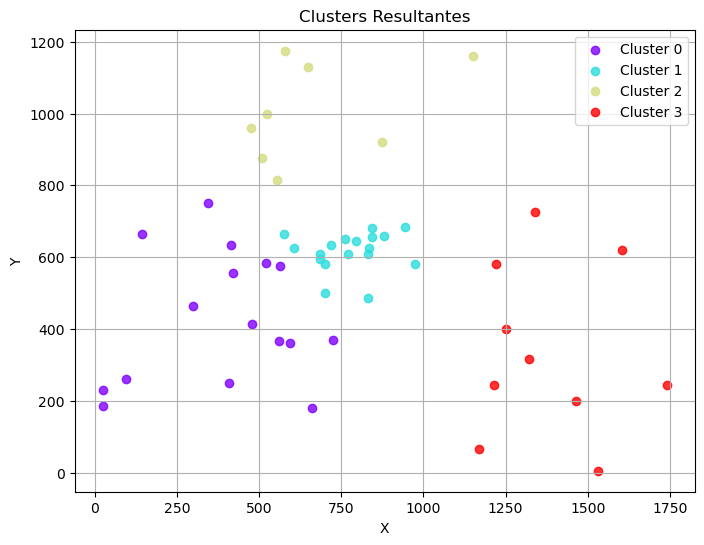

In [21]:
## Test
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

filepath = 'tsplib/berlin52.tsp'
instance = Instance(filepath)

max_size = 20
max_cluster_size = max_size
max_clusters = max_size

# Adiciona os clusters aos nós
data = instance.nodes[:, :2]

try:
    # Clusterizar recursivamente
    clustered_points, centroids = recursive_cluster(data, max_cluster_size)
    # Cores para plotagem
    colors = plt.cm.rainbow(np.linspace(0, 1, len(clustered_points)))

    # Visualizar os clusters
    plt.figure(figsize=(8, 6))
    for i, (cluster, color) in enumerate(zip(clustered_points, colors)):
        plt.scatter(cluster[:, 0], cluster[:, 1], color=color, alpha=0.8, label=f'Cluster {i}')
    plt.title('Clusters Resultantes')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Verifica se o número de clusters gerados ultrapassa max_clusters
    if len(clustered_points) > max_clusters:
        raise MaxClusterError(f"Número de clusters ({len(clustered_points)}) excede o máximo permitido ({max_clusters})")
except MaxClusterError as e:
        print(f"Erro: {e}")


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_chart(x, y, x_label, y_label, title):
    # Criação do DataFrame
    df = pd.DataFrame({
        x_label: x,
        y_label: y
    })

    # Geração de cores diferentes para cada barra
    colors = plt.cm.tab20(np.linspace(0, 1, len(df)))

    # Criação do gráfico de barras
    fig, ax = plt.subplots()
    bars = ax.bar(df[x_label], df[y_label], color=colors)

    # Adição de rótulos e título
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    # Exibir o gráfico
    plt.show()

C = 13


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\an

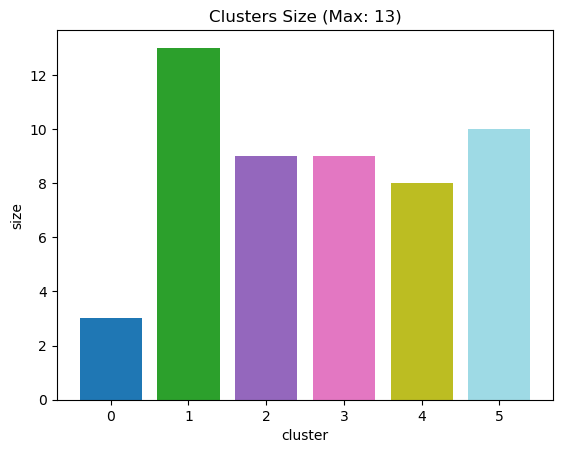

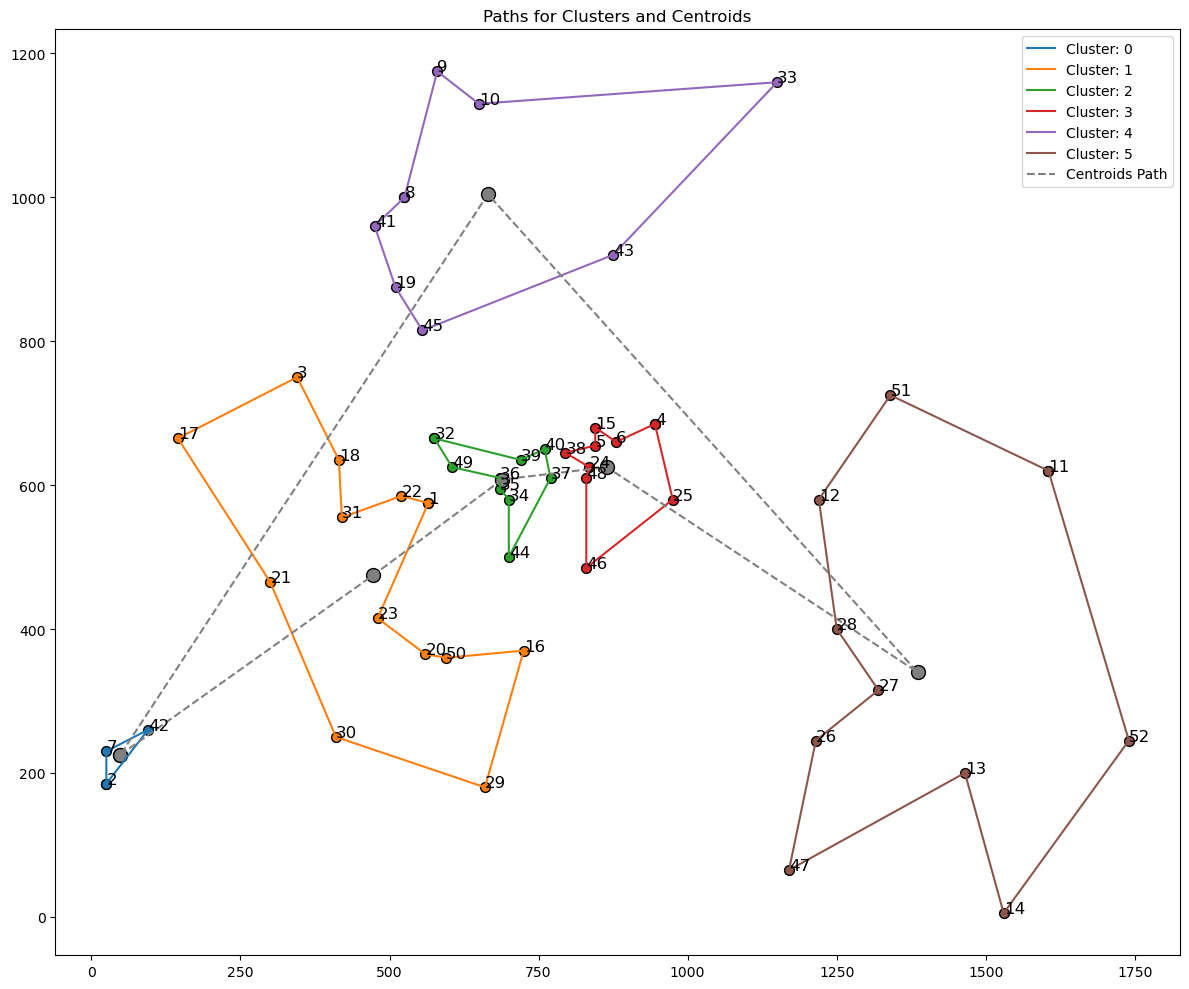

0.0
1.0
2.0
3.0
5.0
4.0


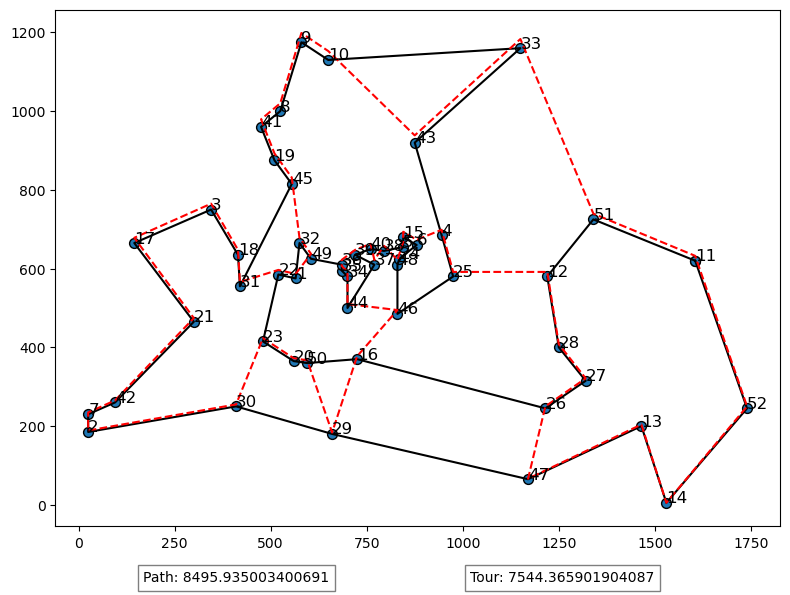

Custo: 8495.93500340069
C = 14


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\an

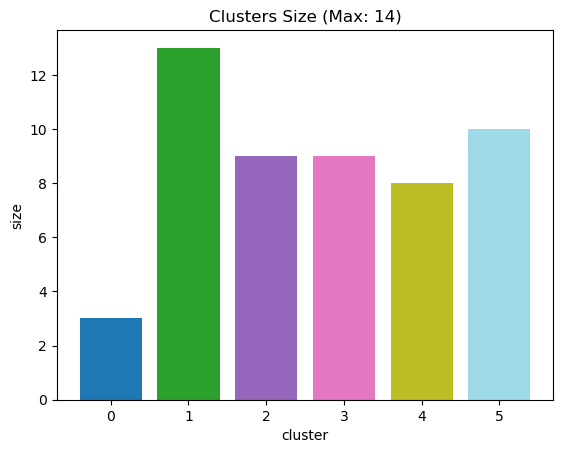

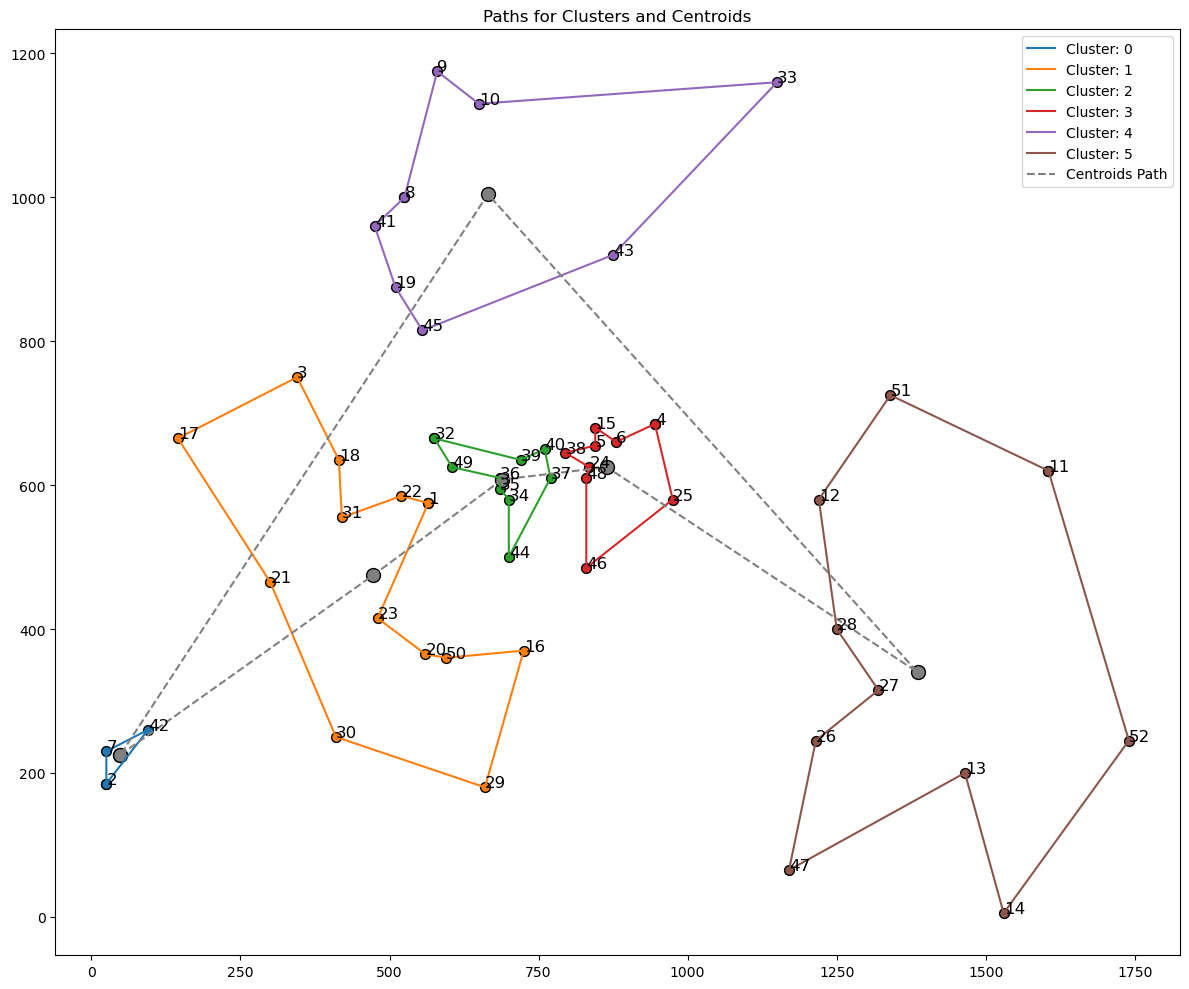

0.0
1.0
2.0
3.0
5.0
4.0


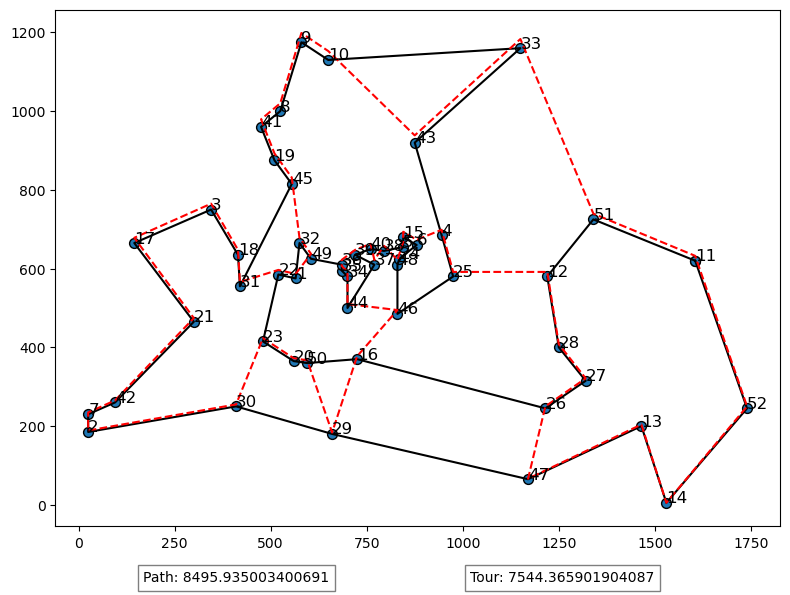

Custo: 8495.93500340069
C = 15


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\an

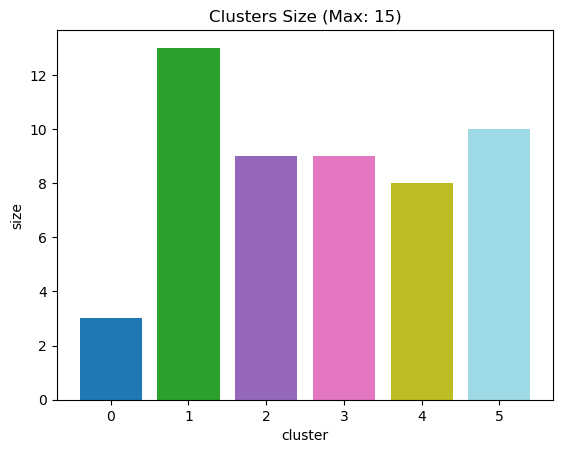

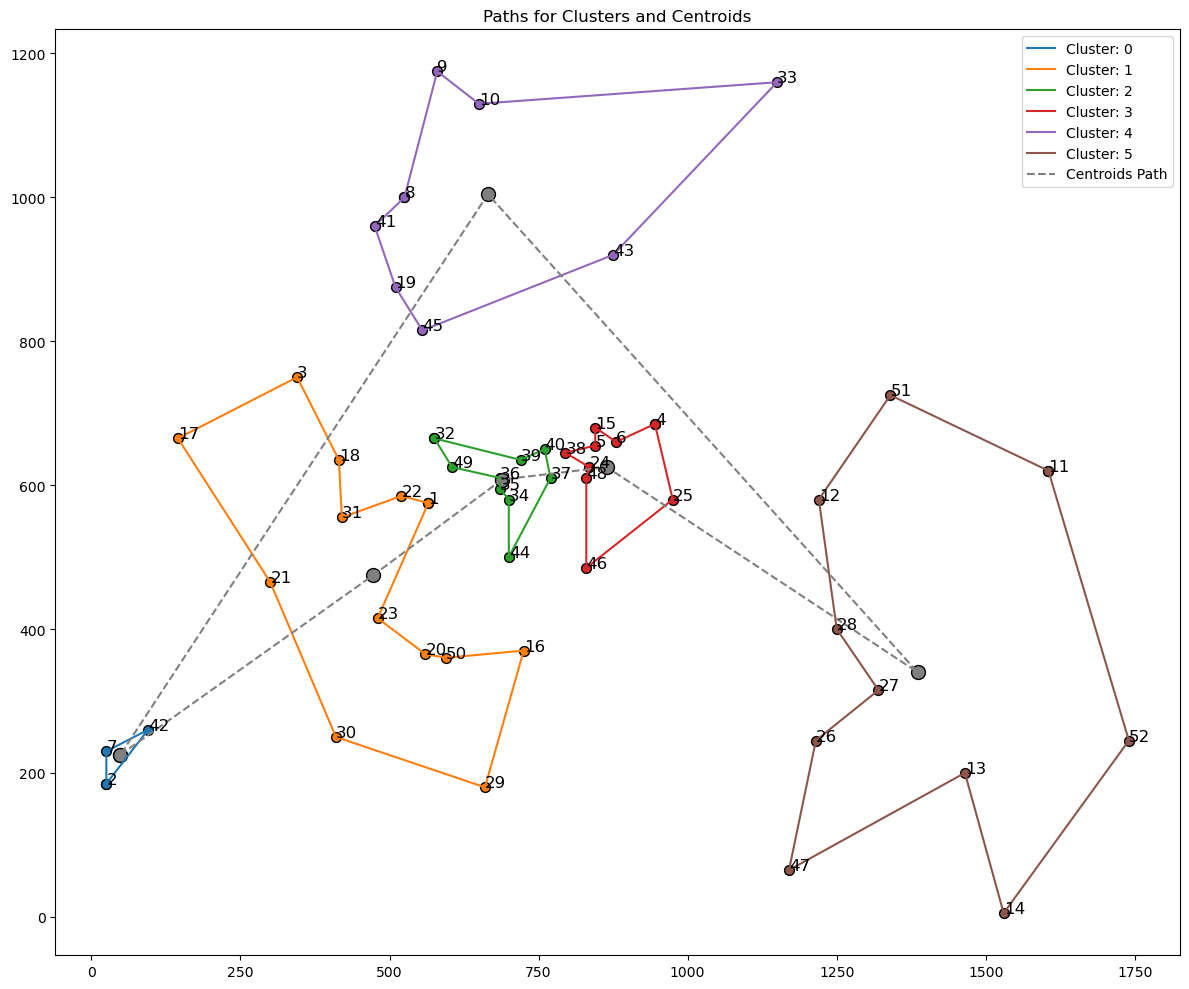

0.0
1.0
2.0
3.0
5.0
4.0


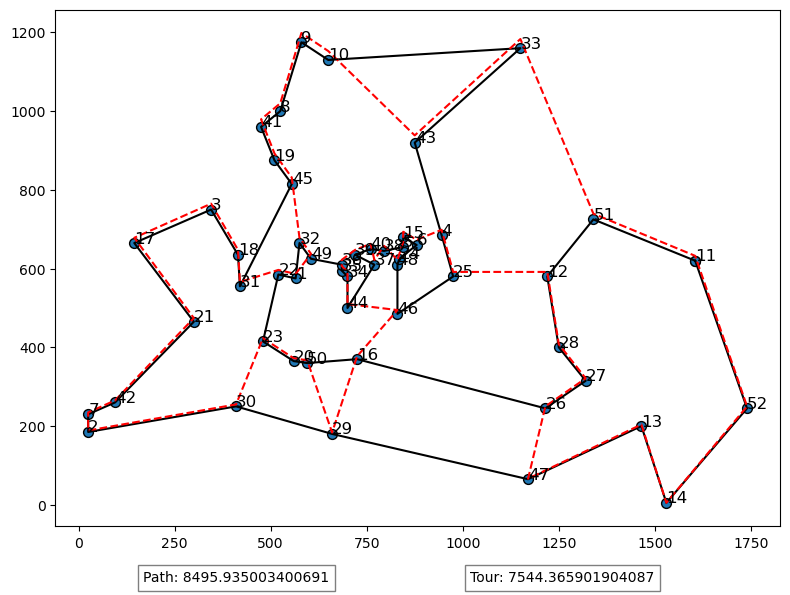

Custo: 8495.93500340069
C = 16


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\an

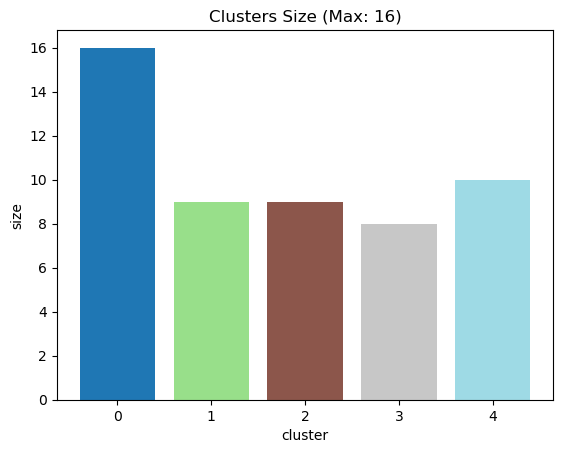

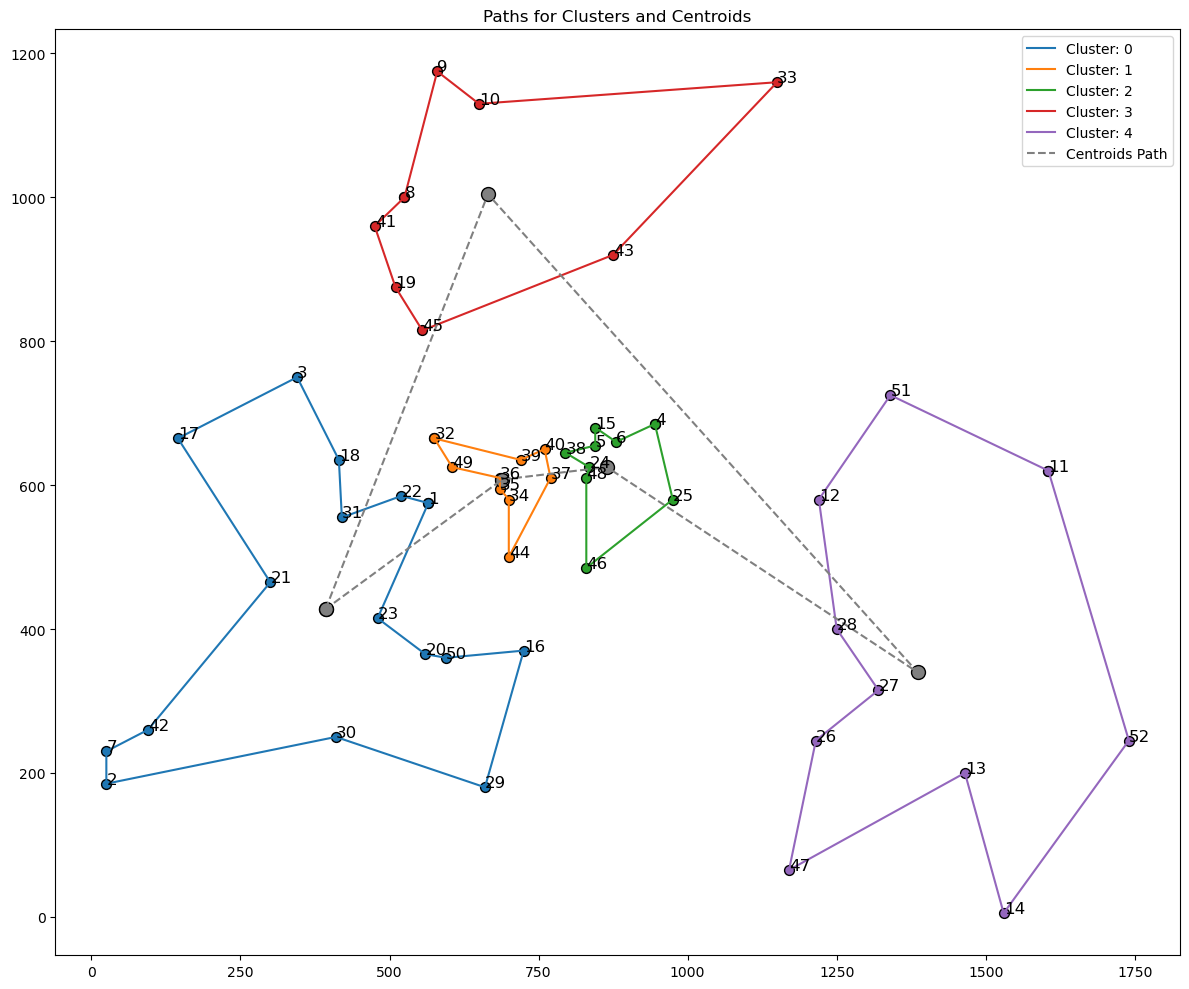

0.0
3.0
4.0
2.0
1.0


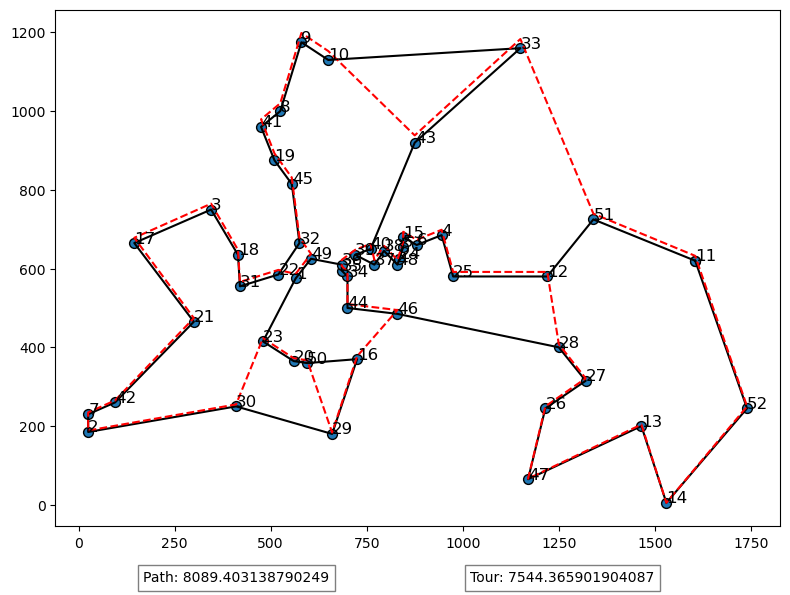

Custo: 8089.403138790248
C = 17


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\an

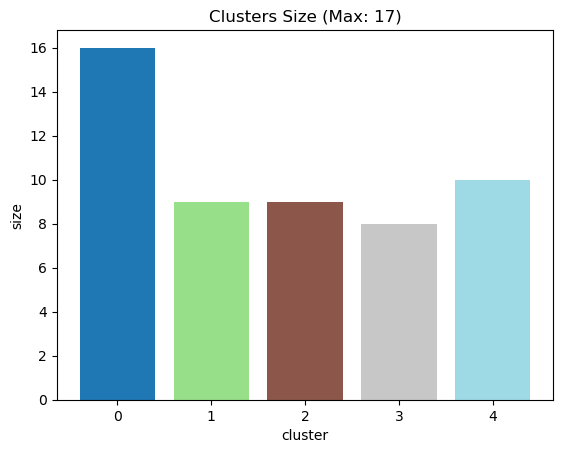

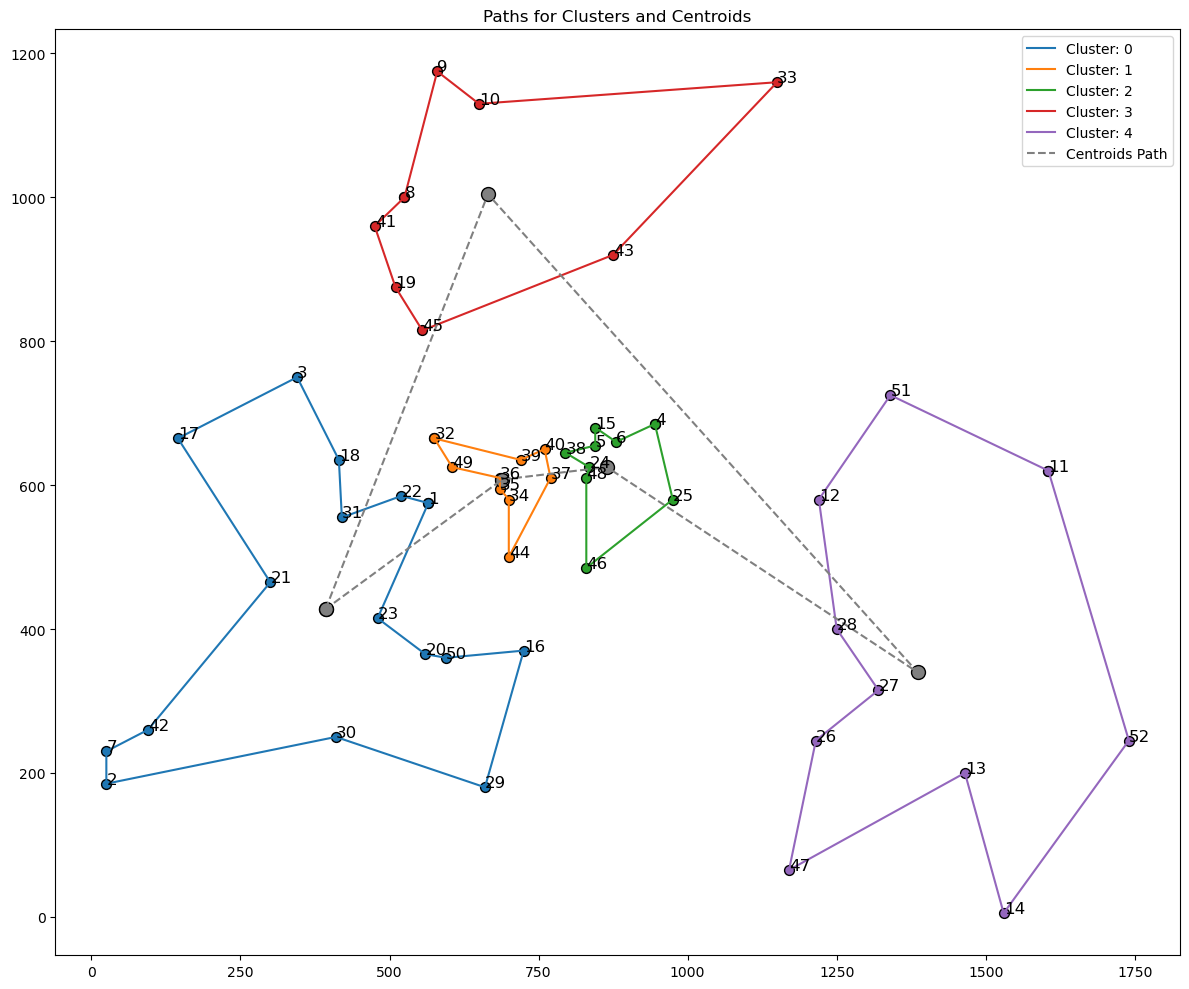

0.0
3.0
4.0
2.0
1.0


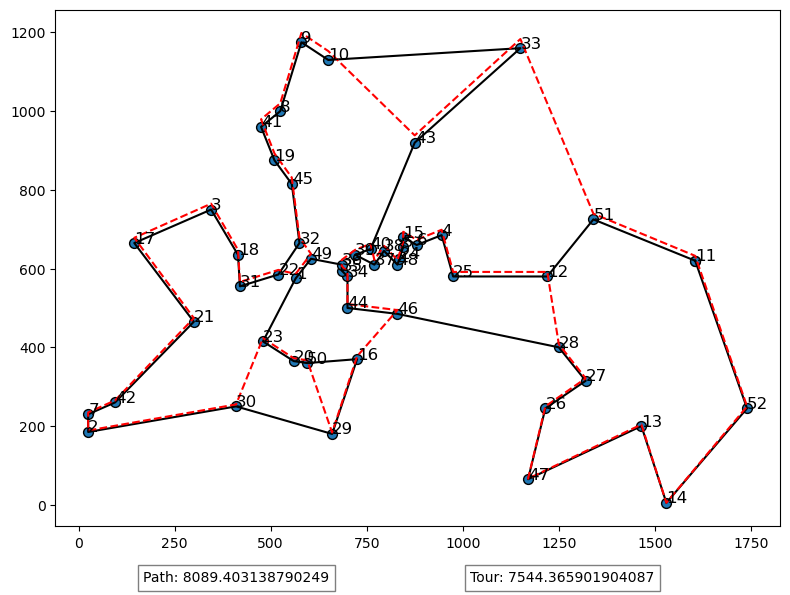

Custo: 8089.403138790248
C = 18


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\an

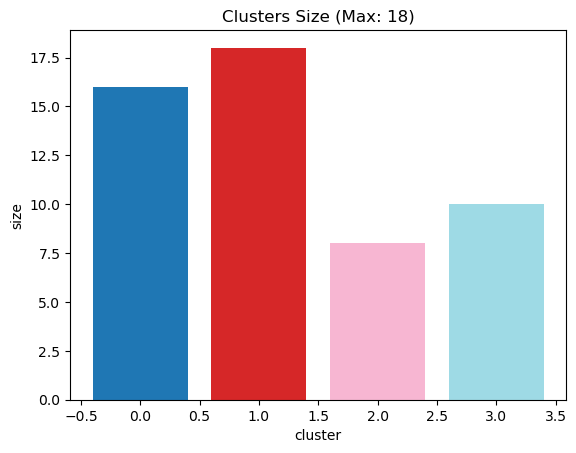

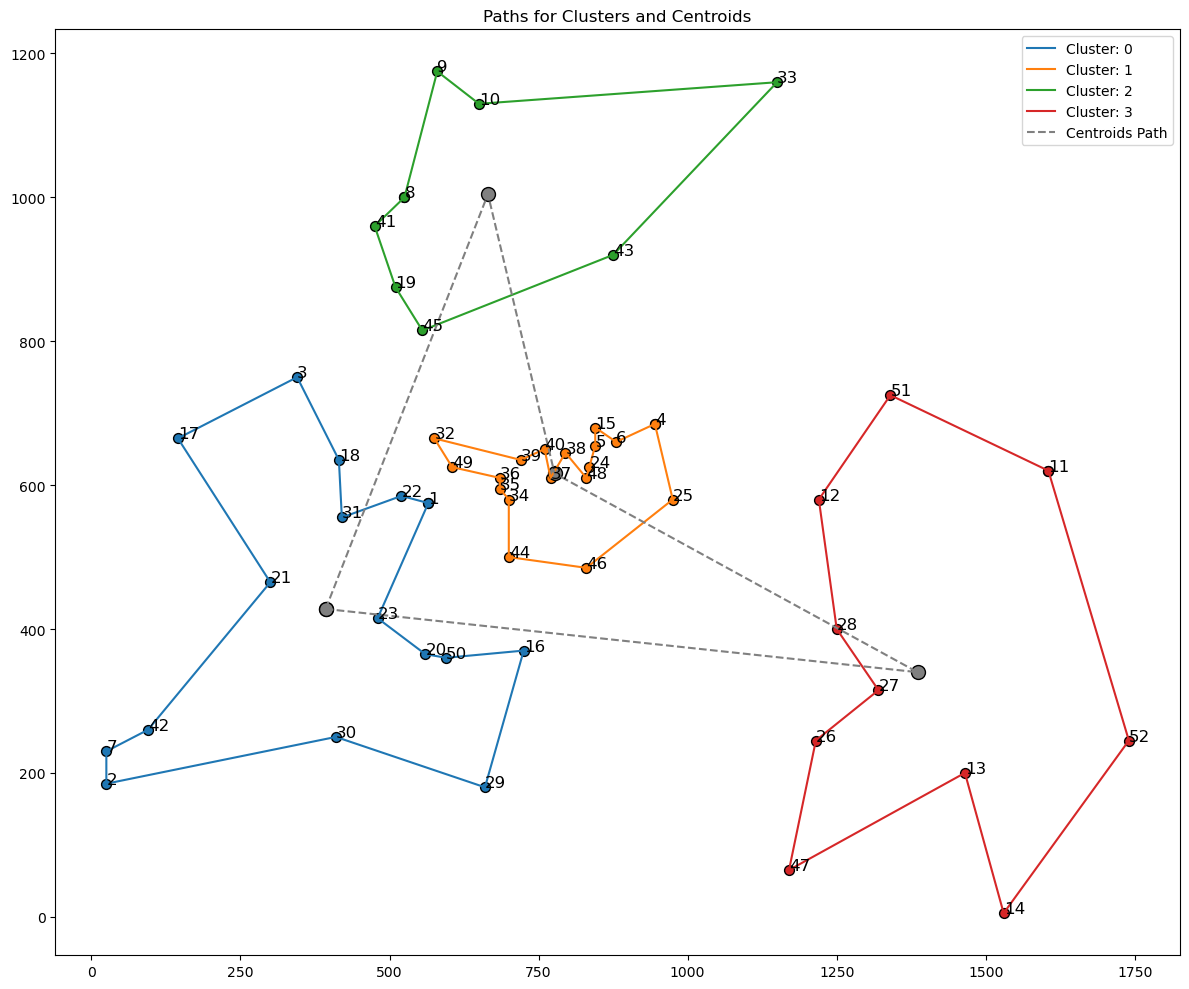

0.0
3.0
1.0
2.0


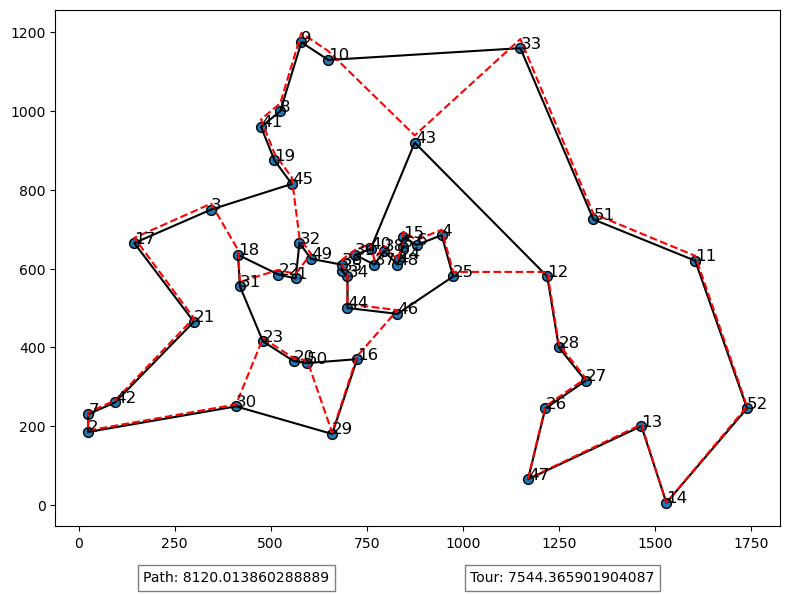

Custo: 8120.013860288887
C = 19


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\User\an

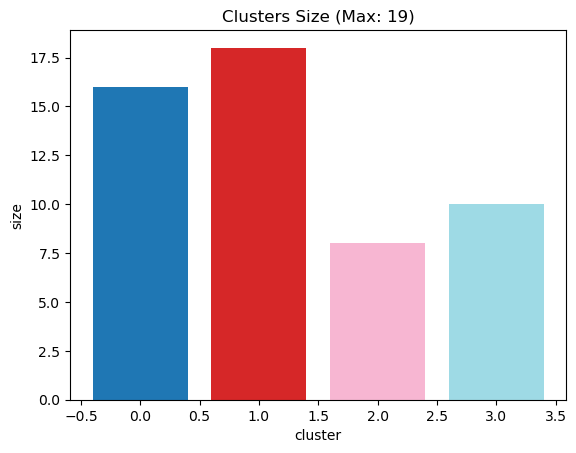

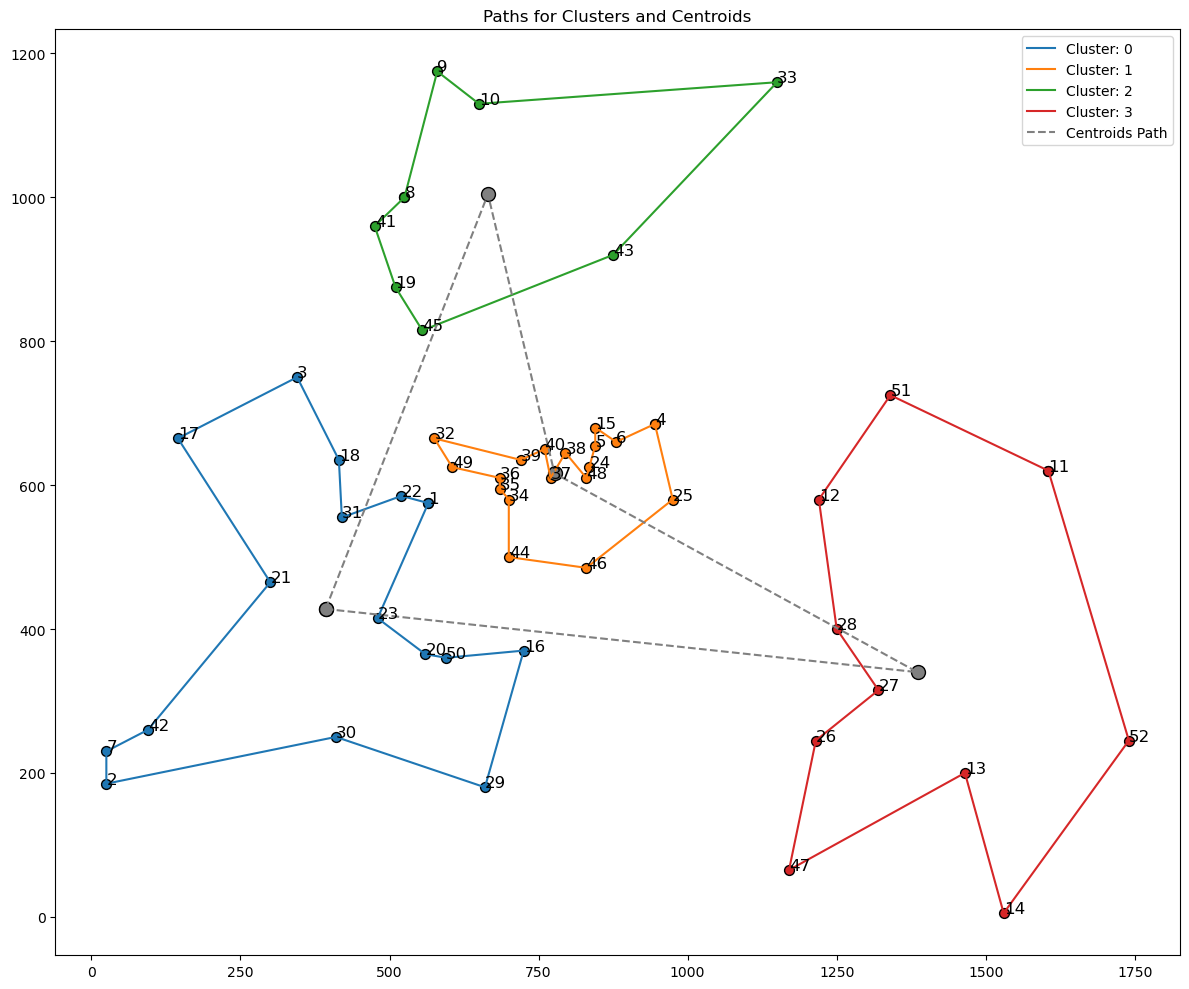

0.0
3.0
1.0
2.0


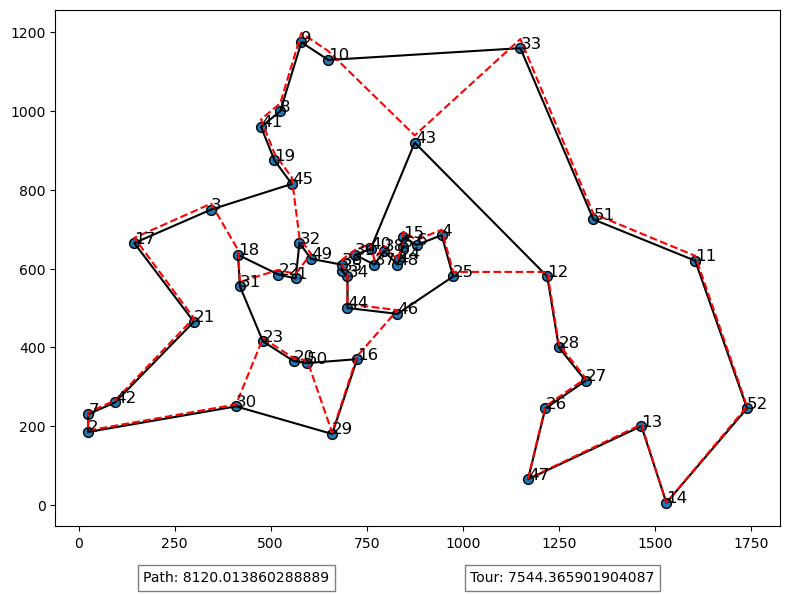

Custo: 8120.013860288887


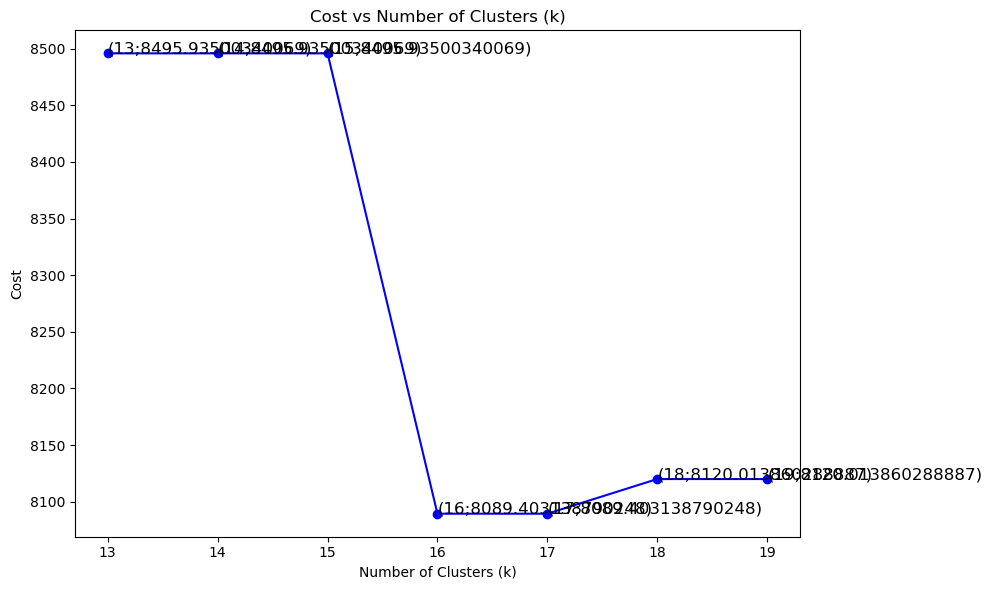

[(13, 8495.93500340069), (14, 8495.93500340069), (15, 8495.93500340069), (16, 8089.403138790248), (17, 8089.403138790248), (18, 8120.013860288887), (19, 8120.013860288887)]


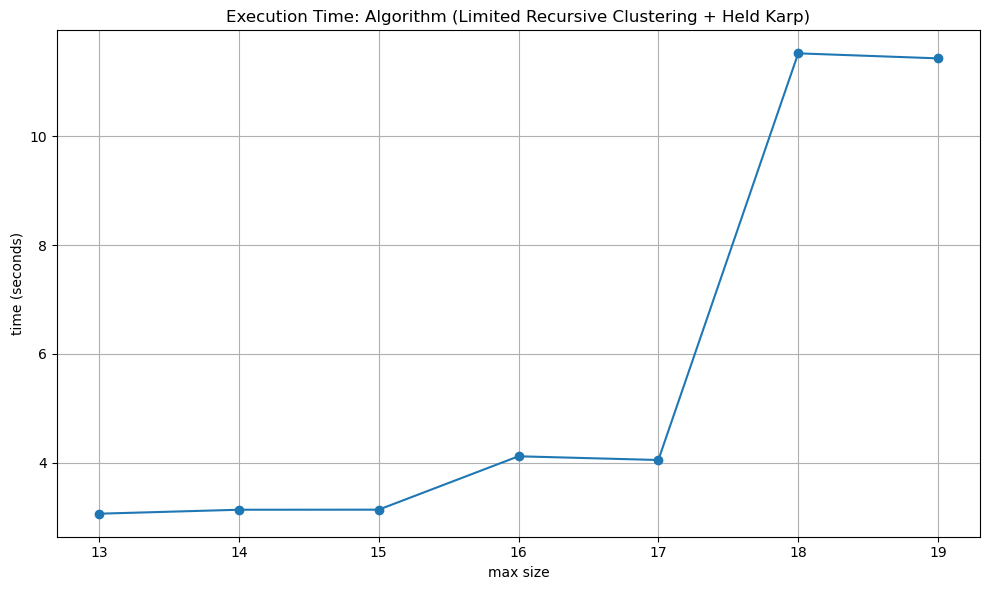

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

class MaxClusterError(Exception):
    pass

filepath = 'tsplib/berlin52.tsp'
instance = Instance(filepath)

s = 13
t = 20

costs = []
execution_times = []
C = []

for max_size in range(s, t):
    print(f'C = {max_size}')
    max_cluster_size = max_size
    max_clusters = max_size
    
    try:
        start_time = time.time()
        # plot_nodes(instance.nodes)

        # Clusterizar recursivamente
        clustered_points, centroids = recursive_cluster(instance.nodes, max_cluster_size)
        
        # Verifica se o número de clusters gerados ultrapassa max_clusters
        if len(clustered_points) > max_clusters:
            raise MaxClusterError(f"Número de clusters ({len(clustered_points)}) excede o máximo permitido ({max_clusters})")

        # Initialize list to store solutions for each cluster
        paths = []
        opts = []
        clusters_size = []

        # Solve each cluster using Held-Karp algorithm
        for cluster in clustered_points:
            clusters_size.append(len(cluster))
            # Solve TSP for the current cluster using Held-Karp algorithm
            opt, path = held_karp(cluster, instance.edge_weight_type)
            #print(f" Optimal Length = {opt}, Path = \n{path}")
            paths.append(path)
            opts.append(opt)
            
        # ==============================
        plot_bar_chart(list(range(0, len(clusters_size))), clusters_size, "cluster", "size", f'Clusters Size (Max: {max_size})')
        # ==============================

        centroid_ids = np.arange(len(centroids)).reshape(-1, 1)
        centroids_with_ids = np.hstack((centroids, centroid_ids))

        opt, path_centroids = held_karp(centroids_with_ids, instance.edge_weight_type)

        # plot_path(path_centroids, opt)
        # print(f"Centroids: Optimal Length = {opt}, Path = \n{path_centroids}")

        plot_path_nodes_and_centroids_no_ids(paths, path_centroids)

        # Matriz de distâncias completa dos nós
        dist_matrix = np.zeros((len(instance.nodes), len(instance.nodes)))
        for i in range(len(instance.nodes)):
            for j in range(len(instance.nodes)):
                dist_matrix[i, j] = distance(instance.nodes[i], instance.nodes[j], instance.edge_weight_type)

        # Reorganize e otimize os caminhos de acordo com a ordem dos centróides
        join = []

        for idx in path_centroids[:, 2]:
            print(idx)
            intra_path = paths[int(idx) - 1]
            min_cost = float('inf')  # Inicializa 'min_cost' com um valor infinito
            min_path = []  # Inicializa 'min_path'
            tam = len(join)
            
            if tam > 0:
                for i in range(tam + 1):  # +1 para considerar inserção no final
                    circulars = circular_permutations(intra_path)
                    # print(f"circulars: {circulars}")
                    for circular in circulars:
                        # print(f"      circular: {circular}")
                        copy = join[:i] + circular + join[i:]
                        # print(f"      copy: {copy}")
                        cost = calculate_total_distance(copy, dist_matrix)
                        if cost < min_cost:
                            min_cost = cost
                            min_path = copy

                # print(f"Melhor permutação: {min_path}")
                join = min_path  # Atualiza 'join' com o caminho de menor custo
            else:
                join.extend(intra_path)
            
            # join = opt2(join, dist_matrix)

            # plot_path(join, calculate_total_distance(join, dist_matrix))

        # Otimizar o caminho final
        join = opt2(join, dist_matrix)
        # plot_path(join, calculate_total_distance(join, dist_matrix))
        
        plot_path_and_tour(join, instance.tour, dist_matrix)
        # Adiciona a caixa de texto com o valor do custo do caminho
        path_cost = calculate_total_distance(join, dist_matrix)
        print(f'Custo: {path_cost}')
        costs.append((max_size, path_cost))

        # Cores para plotagem
        colors = plt.cm.rainbow(np.linspace(0, 1, len(clustered_points)))

        # Visualizar os clusters
        # plt.figure(figsize=(8, 6))
        # for i, (cluster, color) in enumerate(zip(clustered_points, colors)):
        #     plt.scatter(cluster[:, 0], cluster[:, 1], color=color, alpha=0.8, label=f'Cluster {i}')
        # plt.title('Clusters Resultantes')
        # plt.xlabel('X')
        # plt.ylabel('Y')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        
        end_time = time.time()
        execution_times.append(end_time-start_time)
        C.append(max_size)

    except MaxClusterError as e:
        print(f"Erro: {e}")
        continue
    
plot_costs(costs)
print(costs)

plot_execution_time(C, execution_times, "max size", "time (seconds)", "Execution Time: Algorithm (Limited Recursive Clustering + Held Karp)")
# ===================================================
# ===================================================
# ===================================================

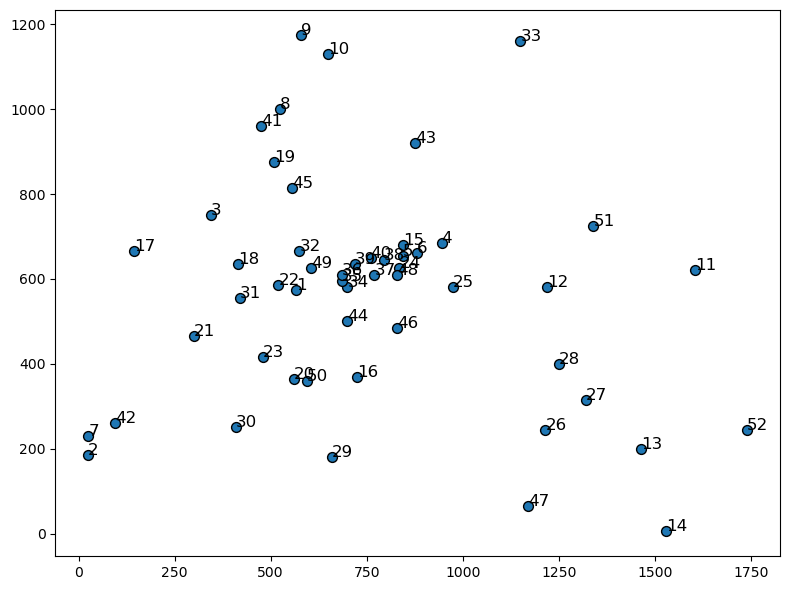

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Skipping cluster with K = 1 exceeds 20 nodes.


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Skipping cluster with K = 2 exceeds 20 nodes.


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Skipping cluster with K = 3 exceeds 20 nodes.


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



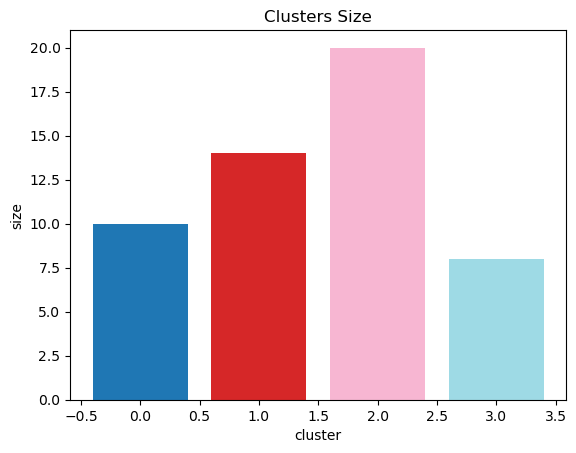

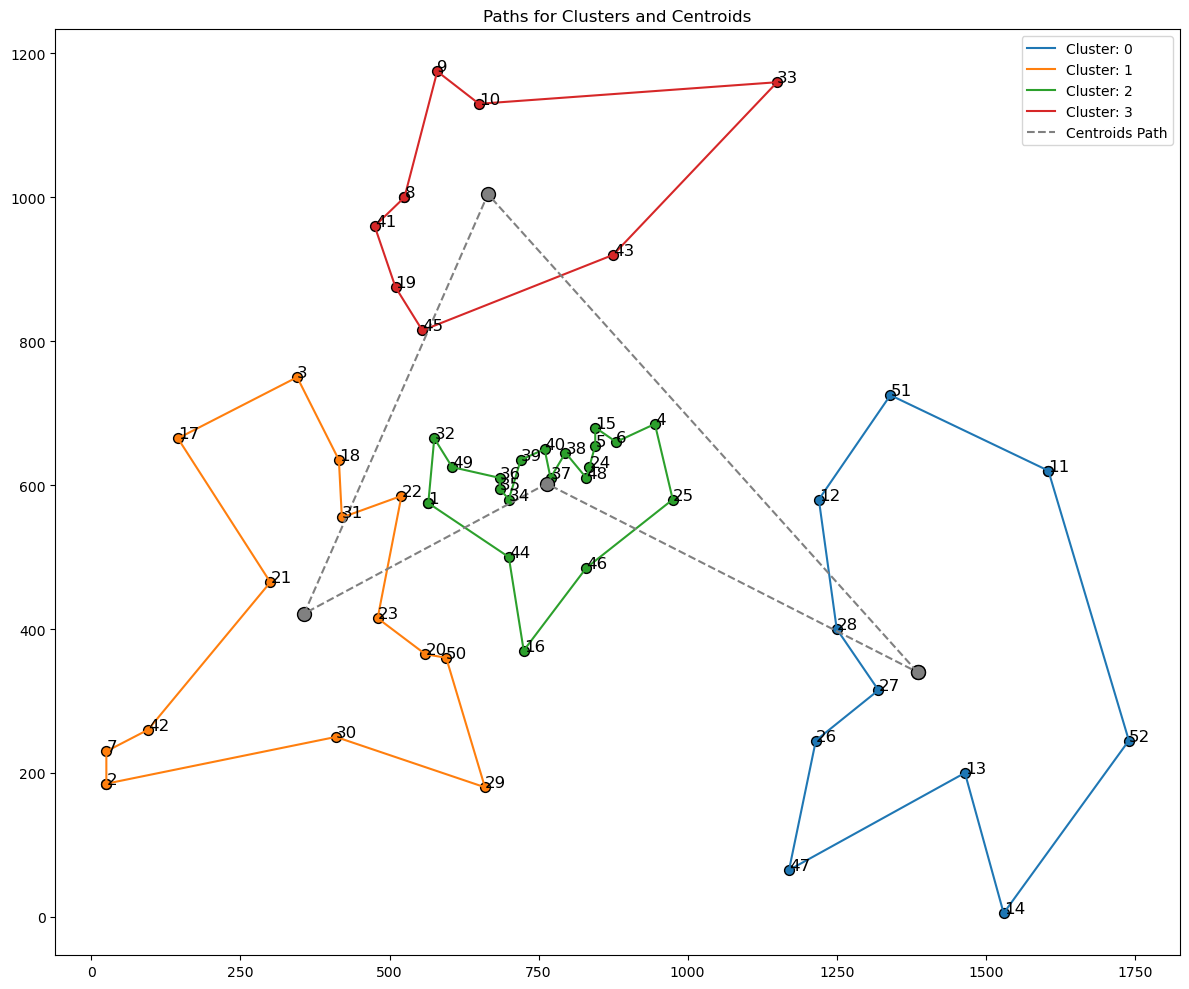

K: 4
Custo: 7922.109218047037


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



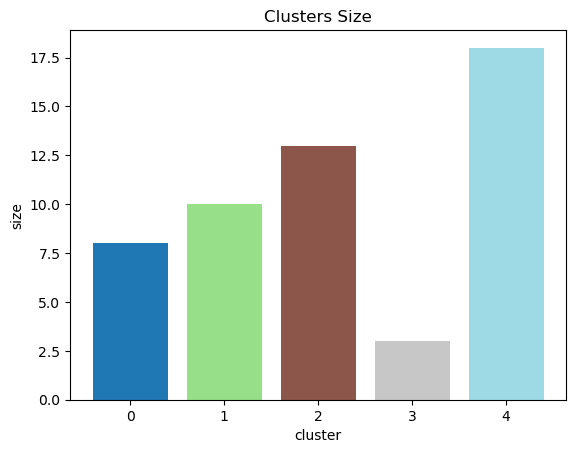

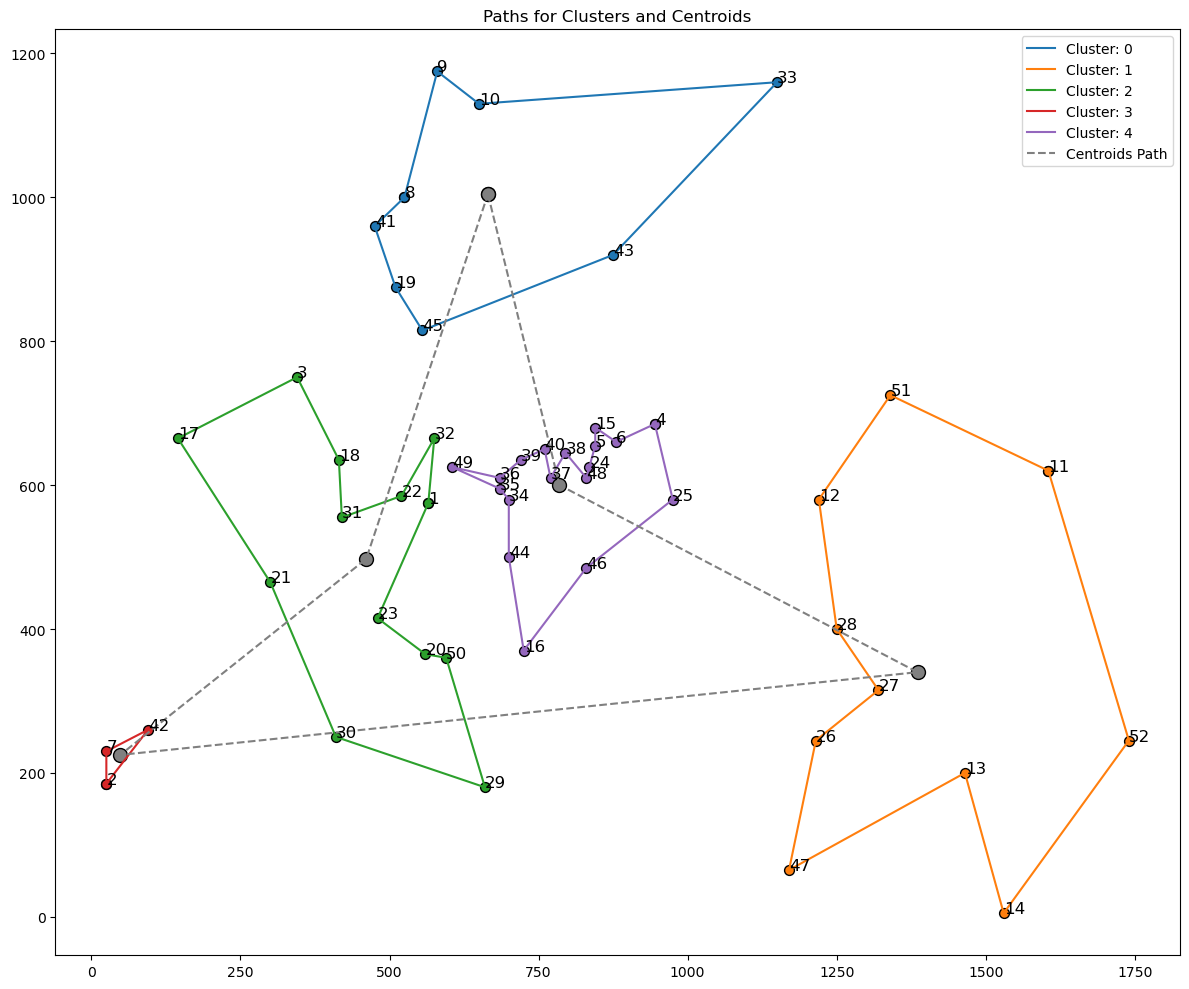

K: 5
Custo: 8212.263189795054


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



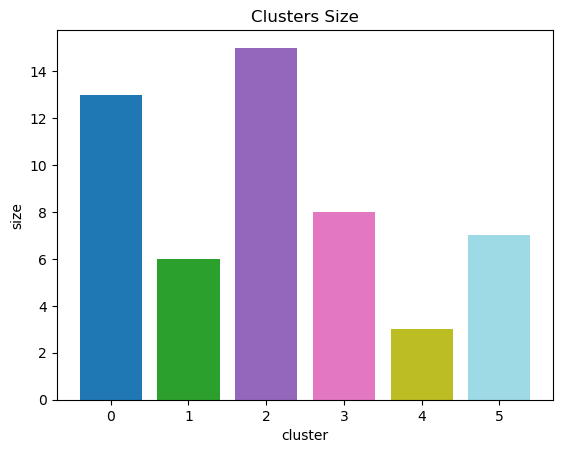

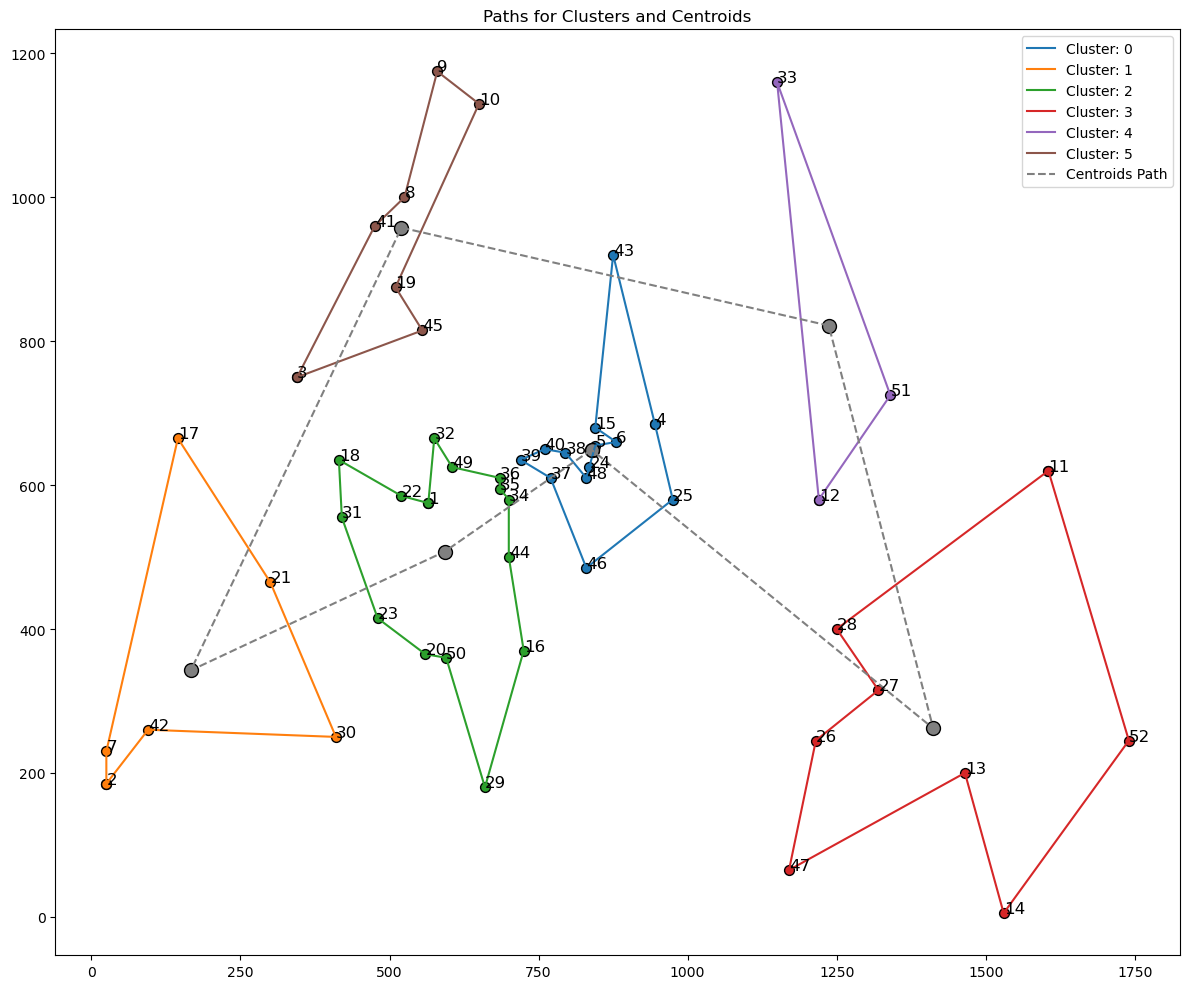

K: 6
Custo: 7896.792743041034


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



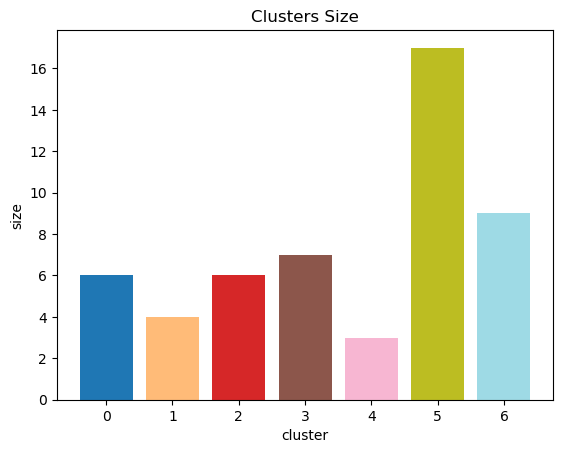

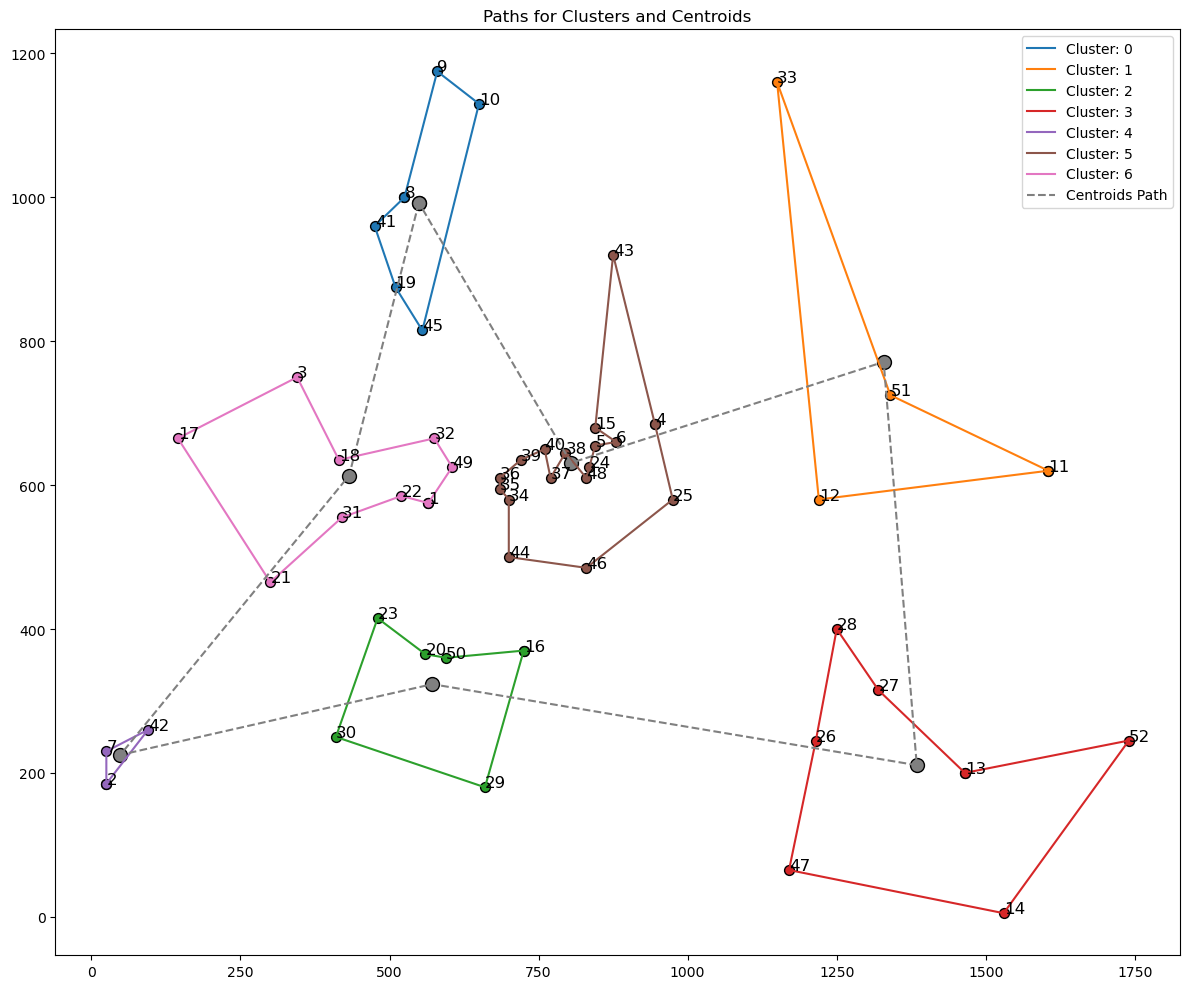

K: 7
Custo: 8392.553775107981


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



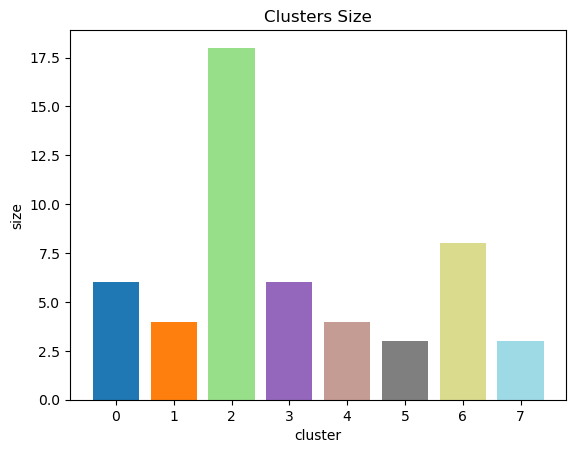

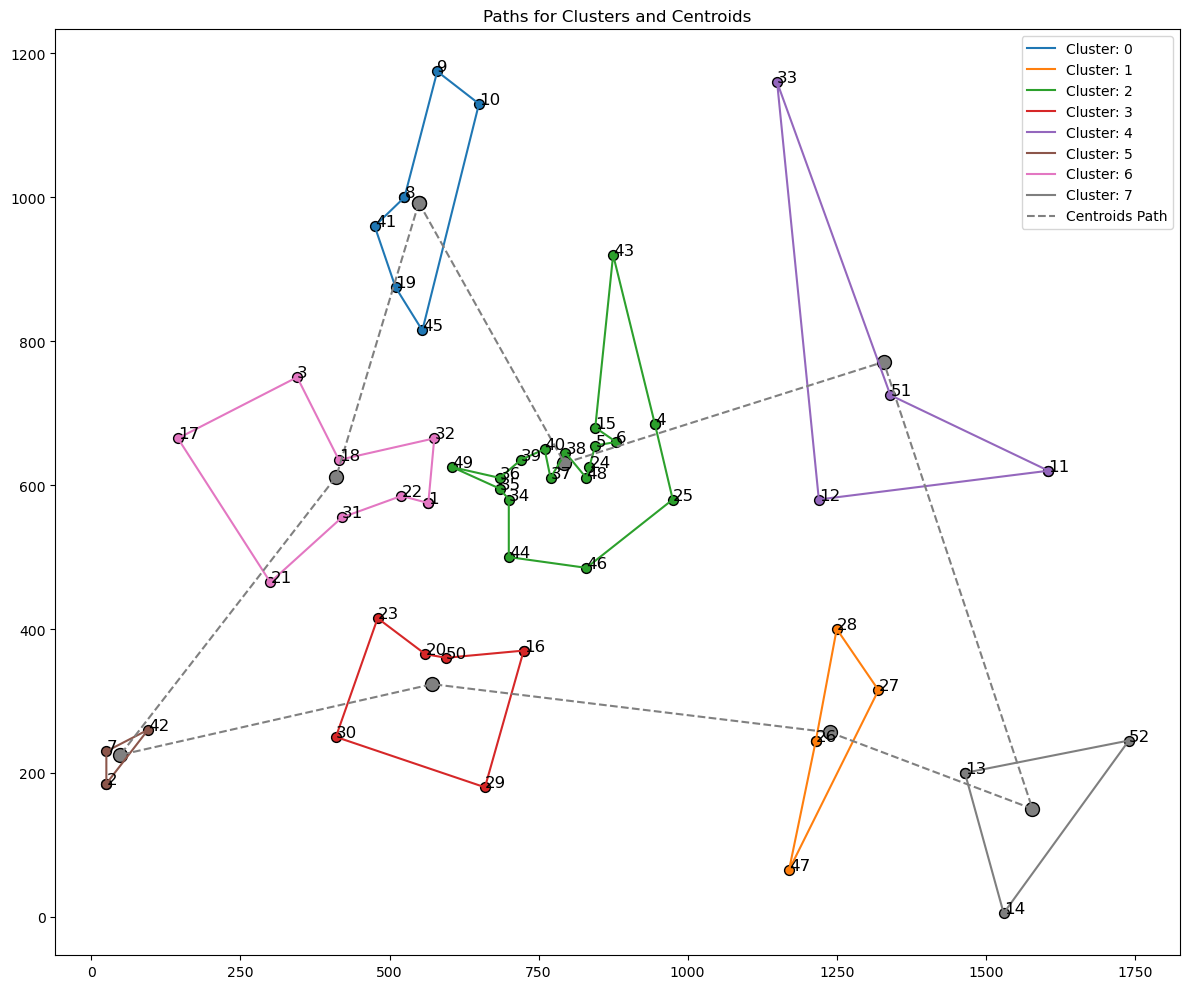

K: 8
Custo: 8671.085010523986


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



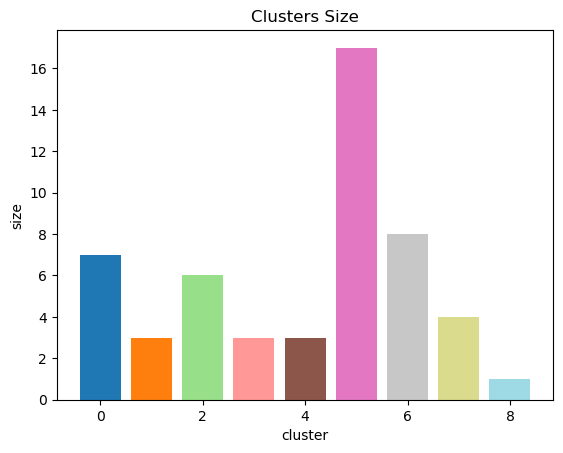

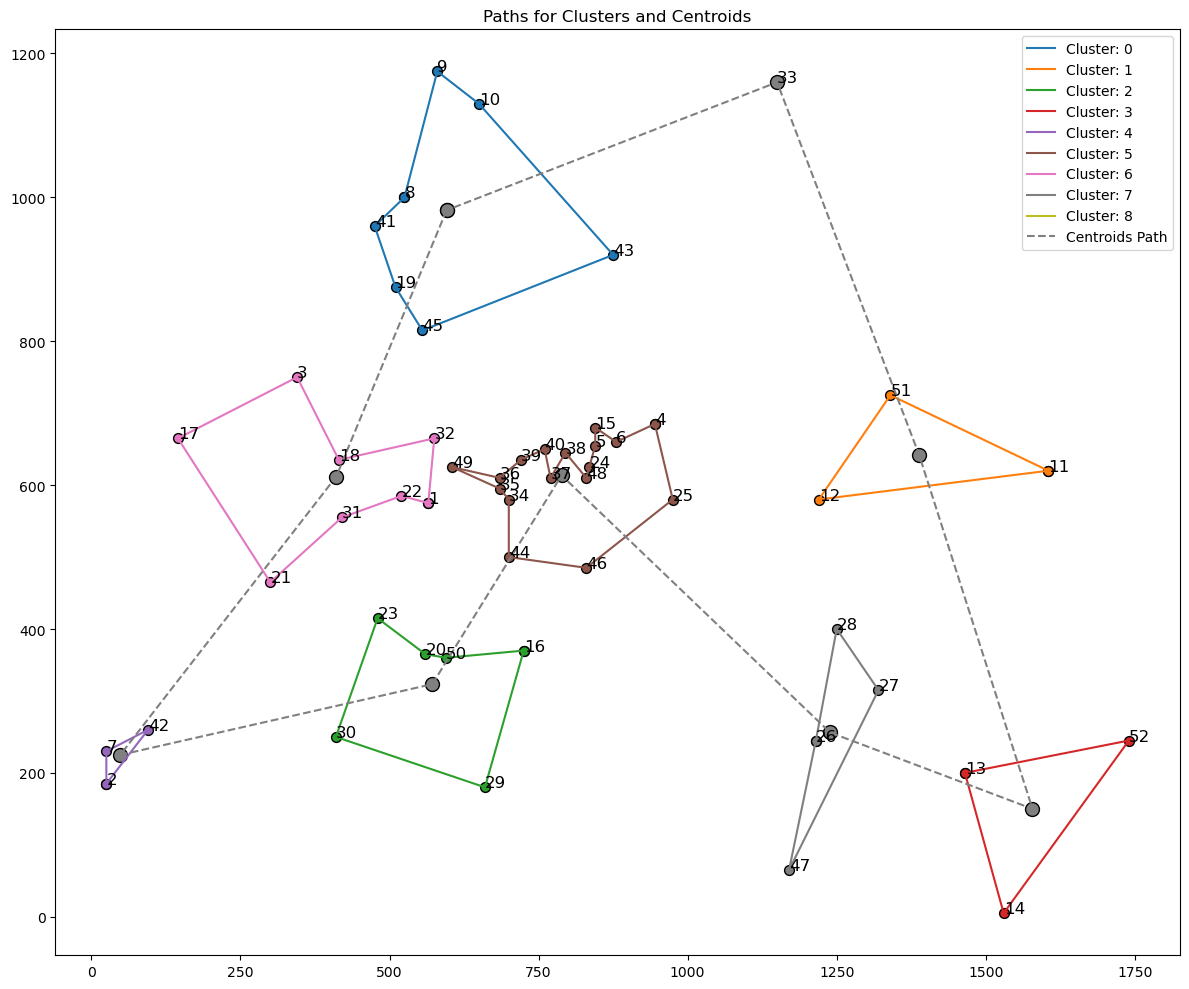

K: 9
Custo: 7864.6620236951885


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



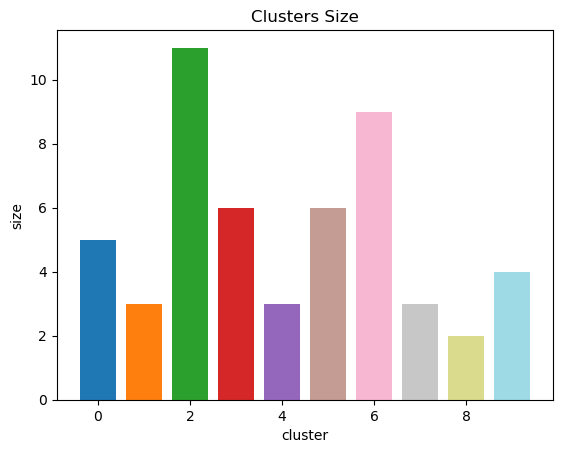

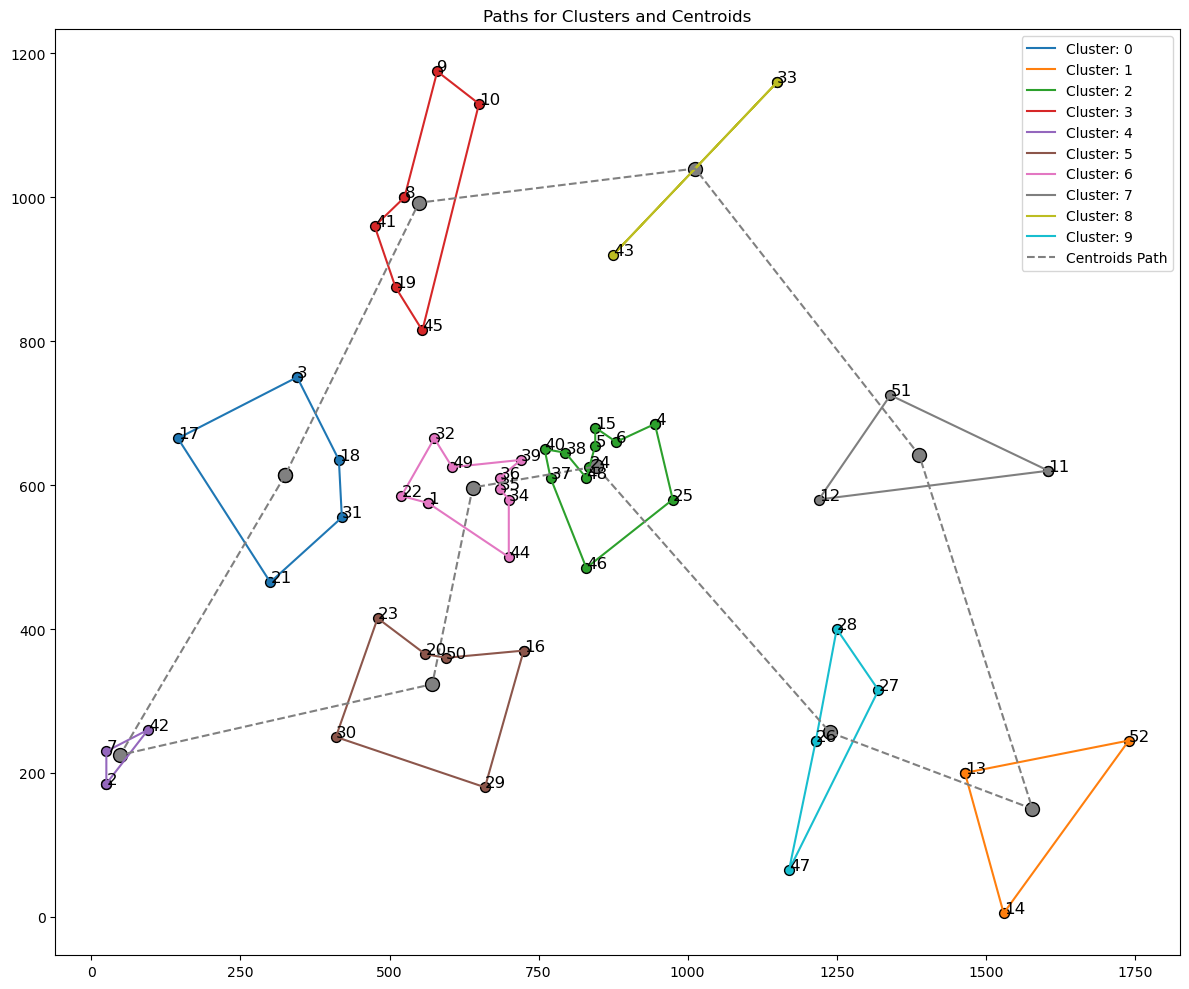

K: 10
Custo: 8098.750986603904


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



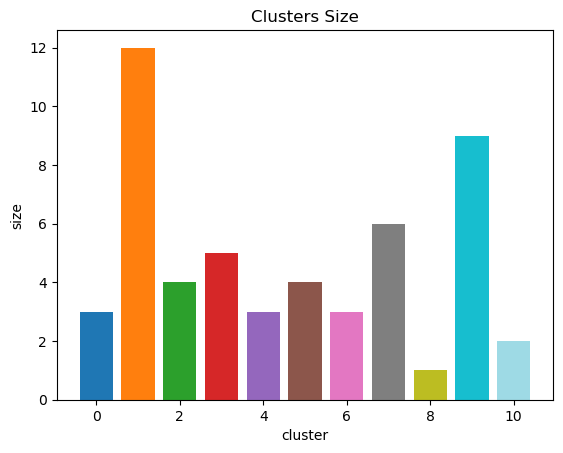

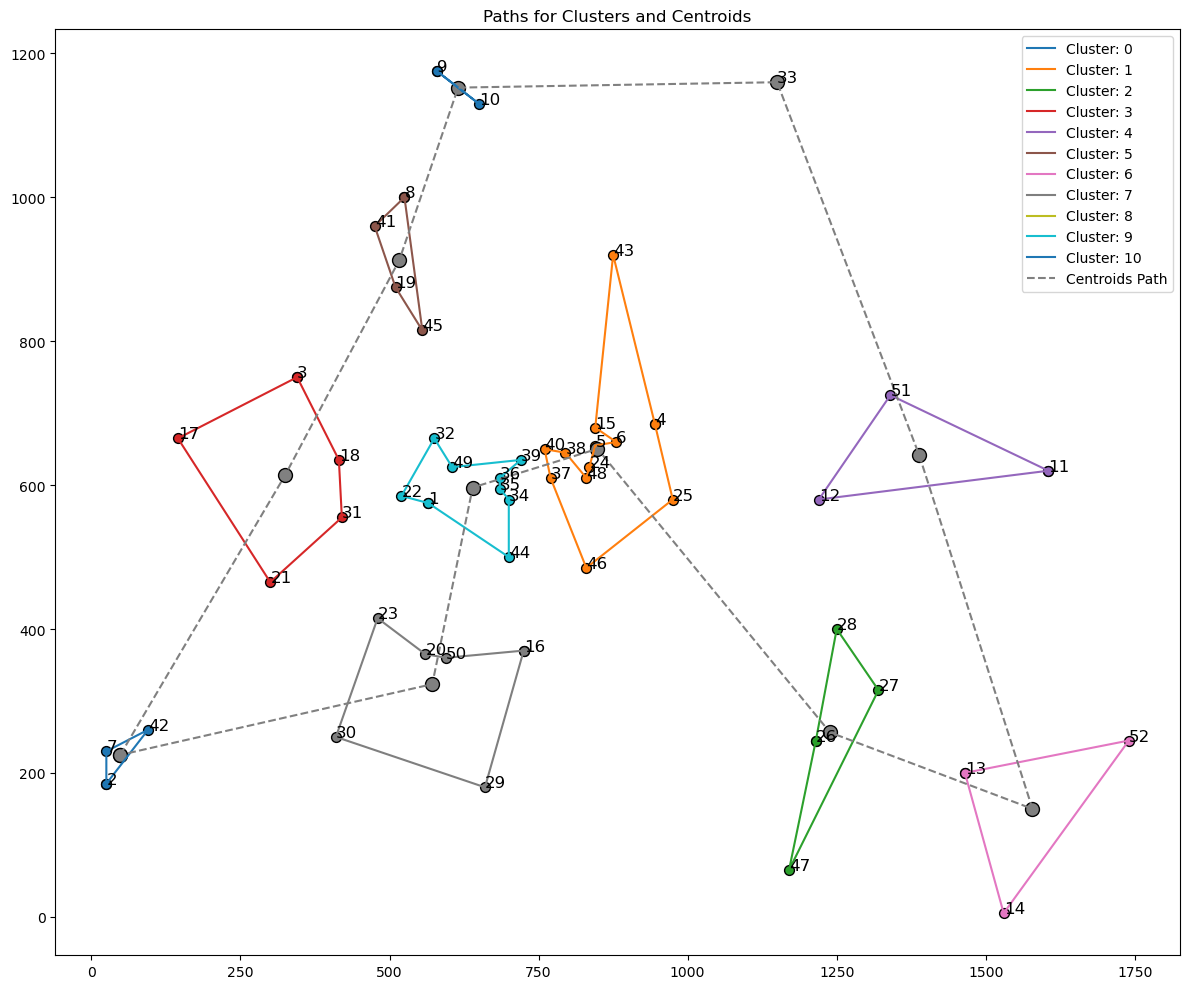

K: 11
Custo: 8138.412146360433


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



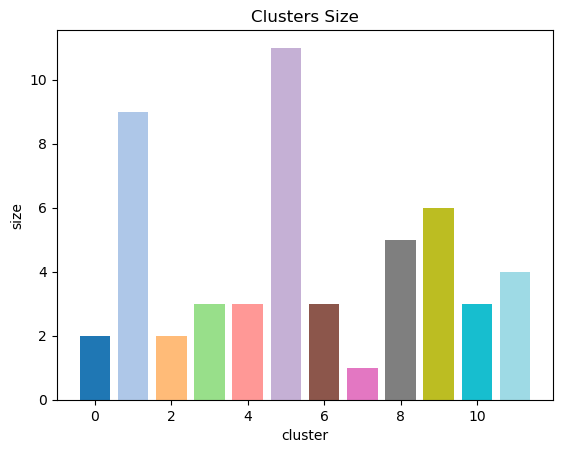

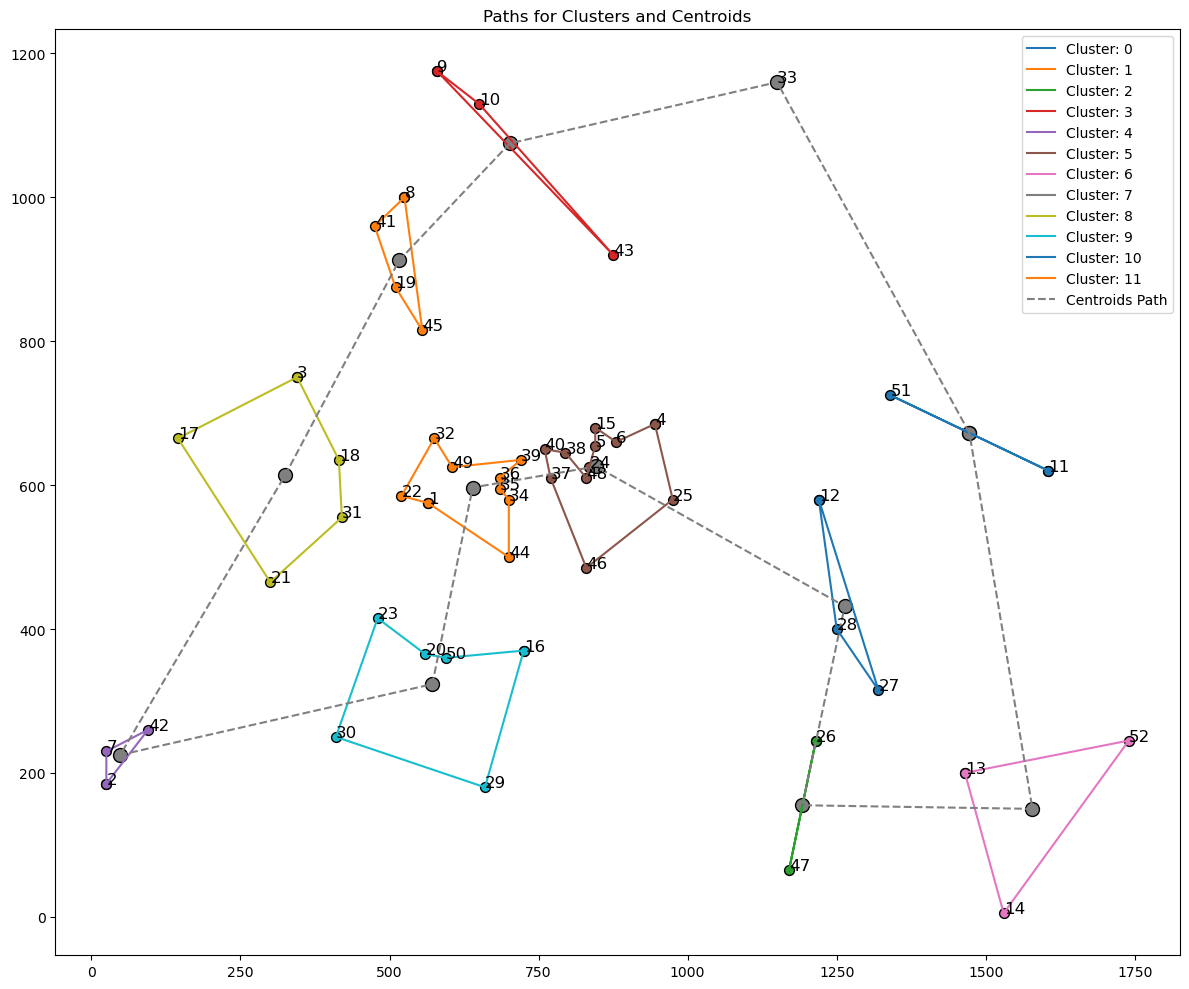

K: 12
Custo: 8148.621875750707


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



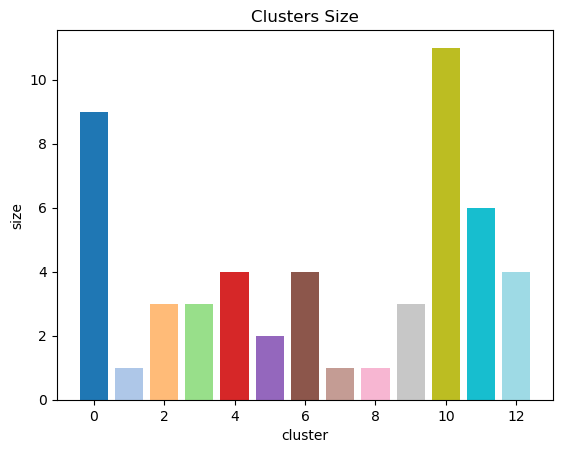

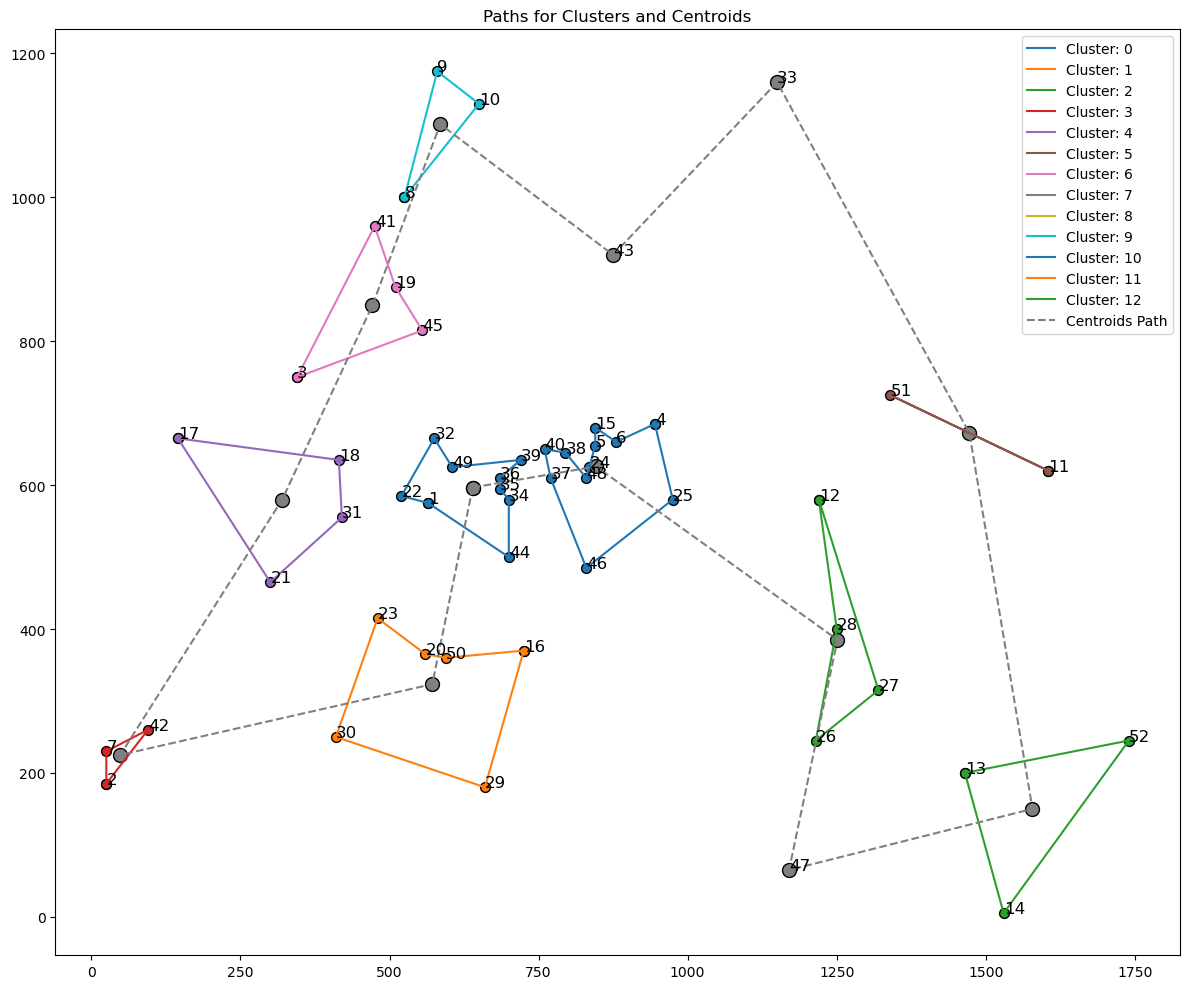

K: 13
Custo: 8619.644257951803


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



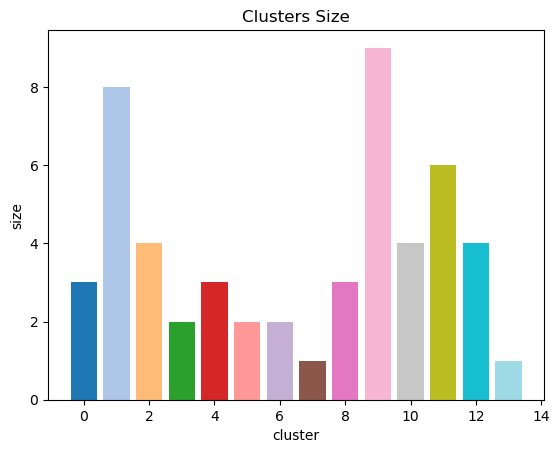

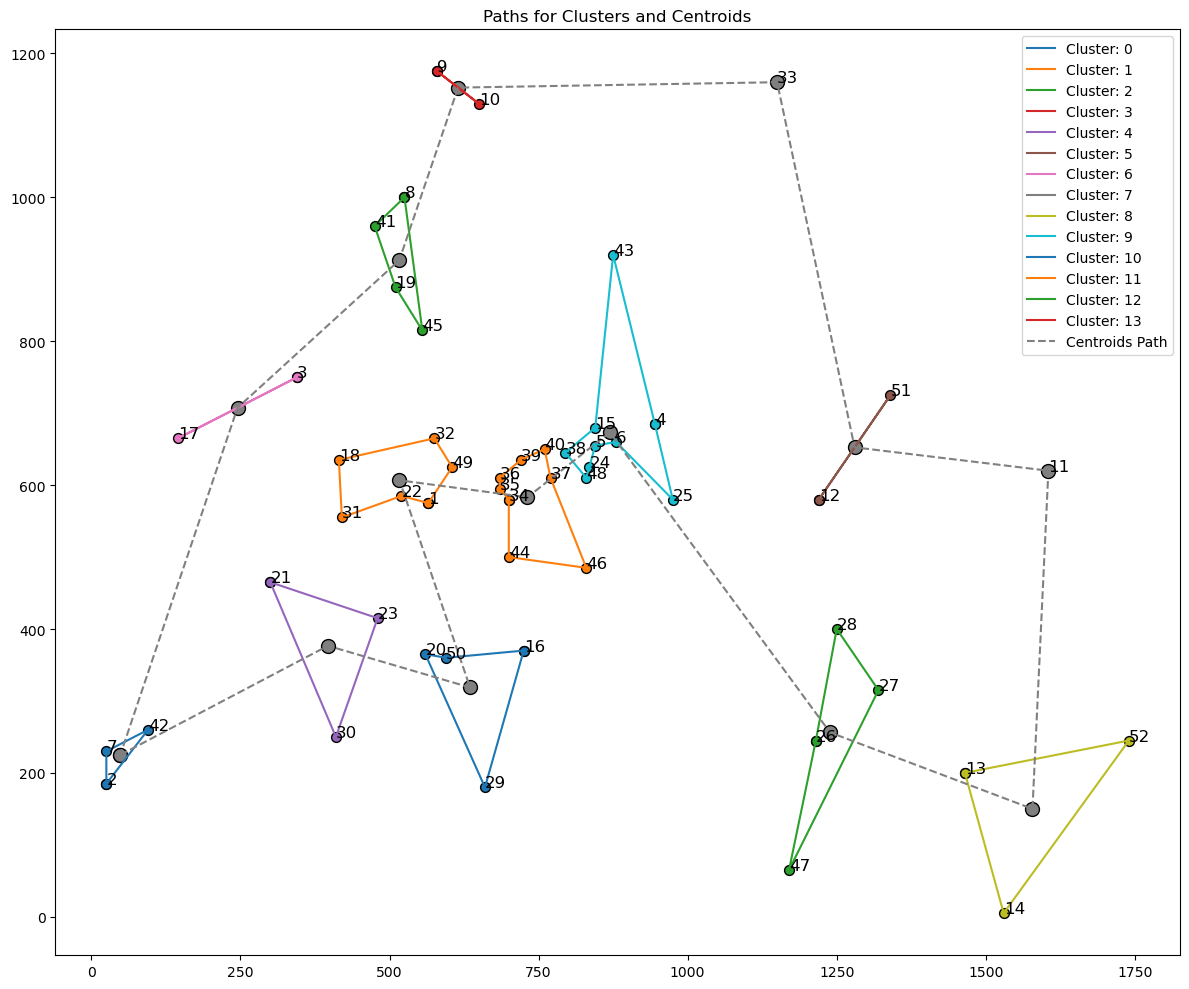

K: 14
Custo: 8340.70548867977


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



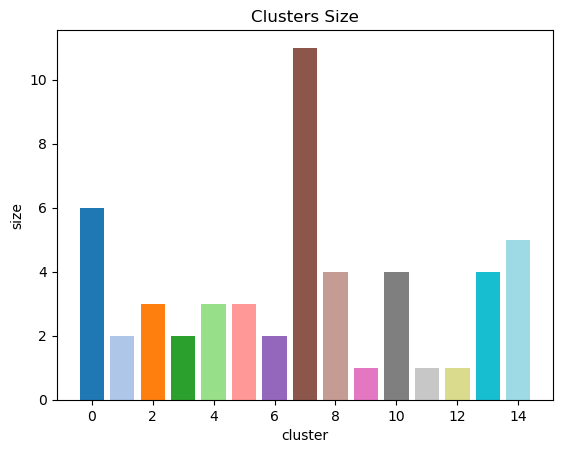

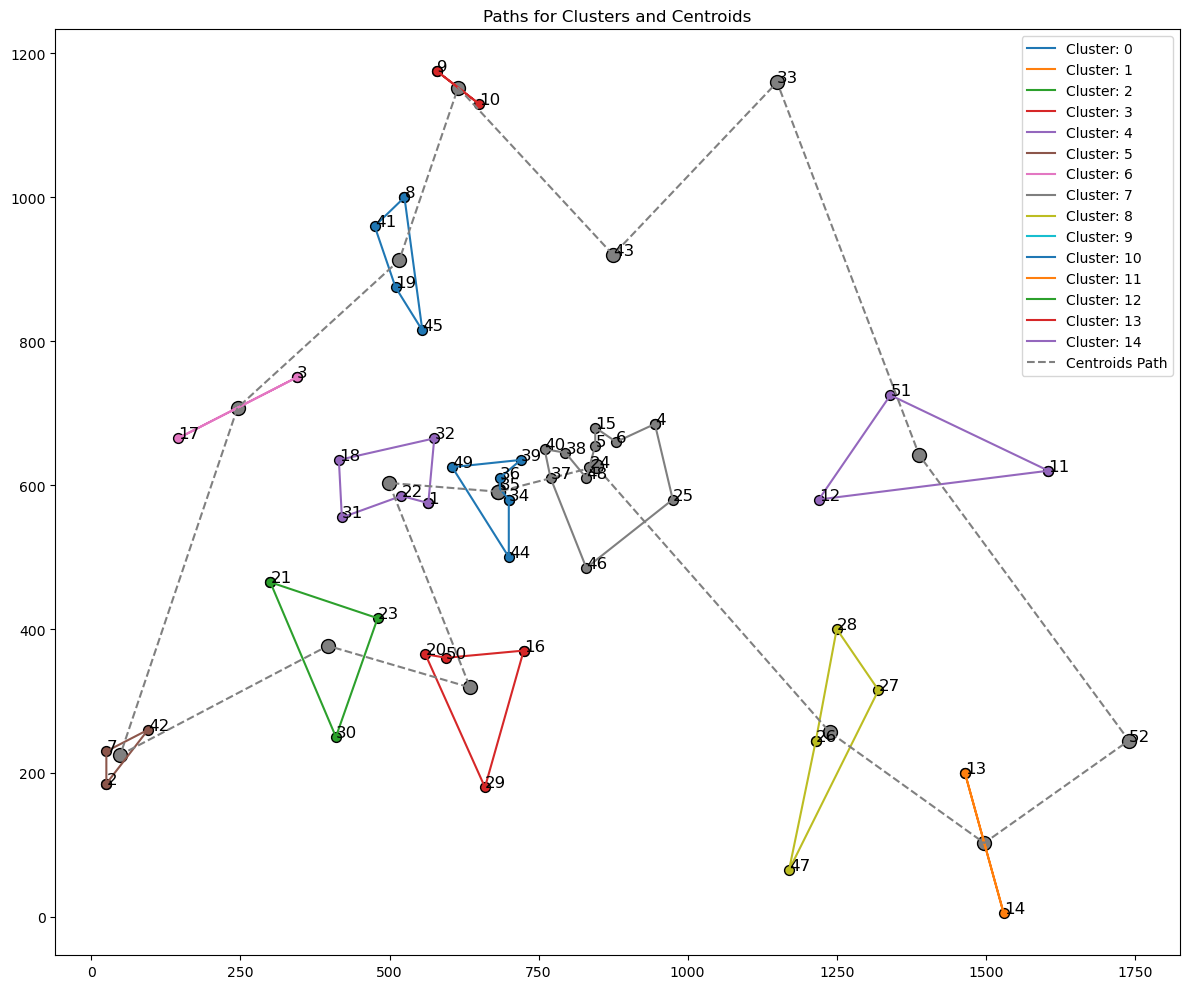

K: 15
Custo: 8065.368709262879


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



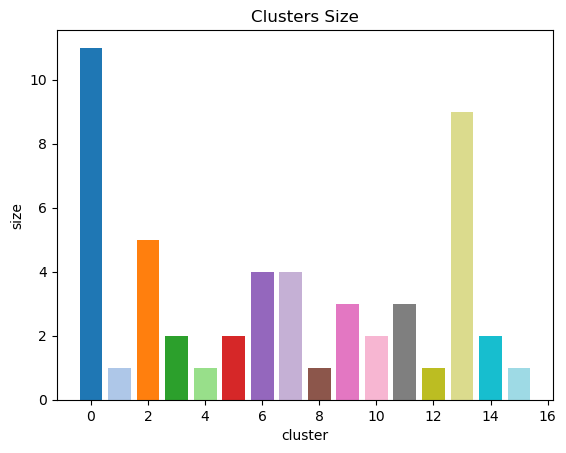

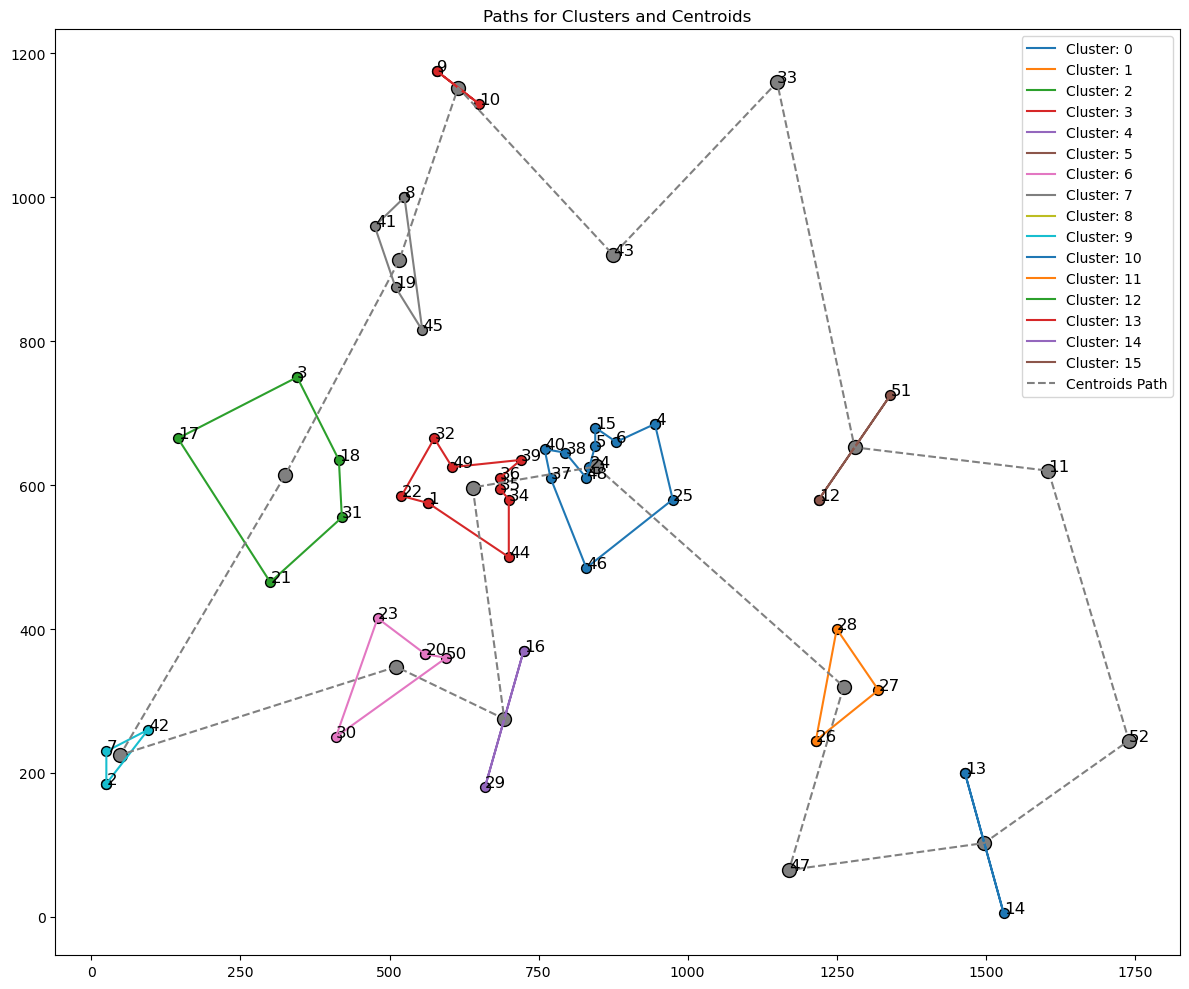

K: 16
Custo: 8009.037858303771


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



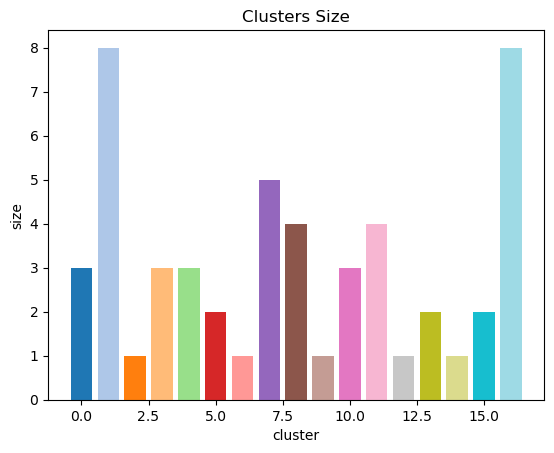

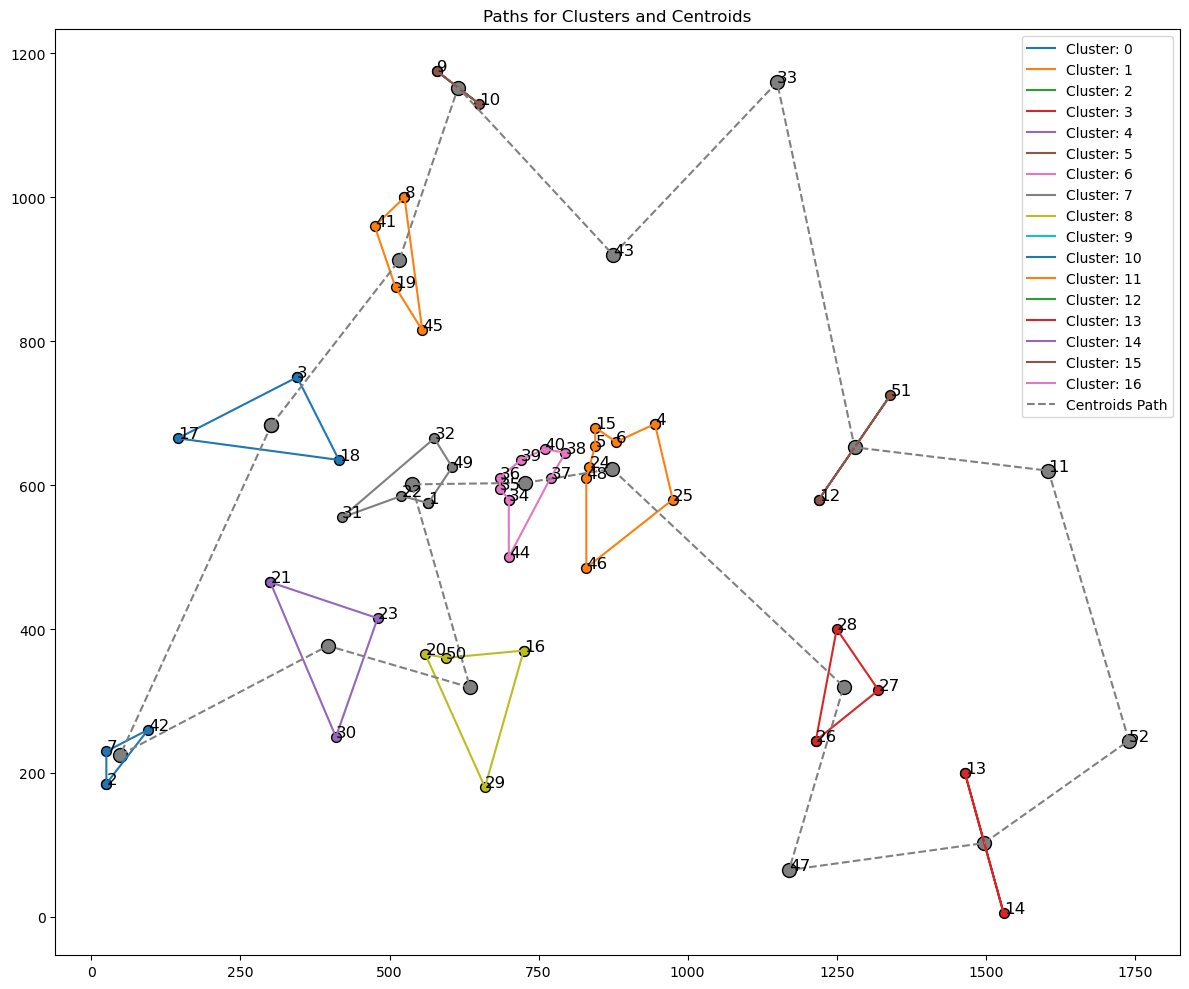

K: 17
Custo: 8322.998345142876


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



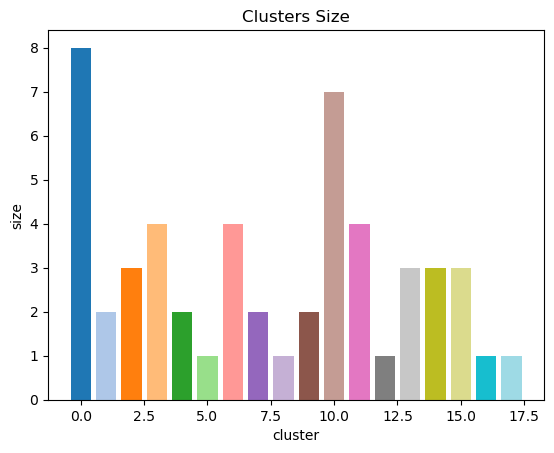

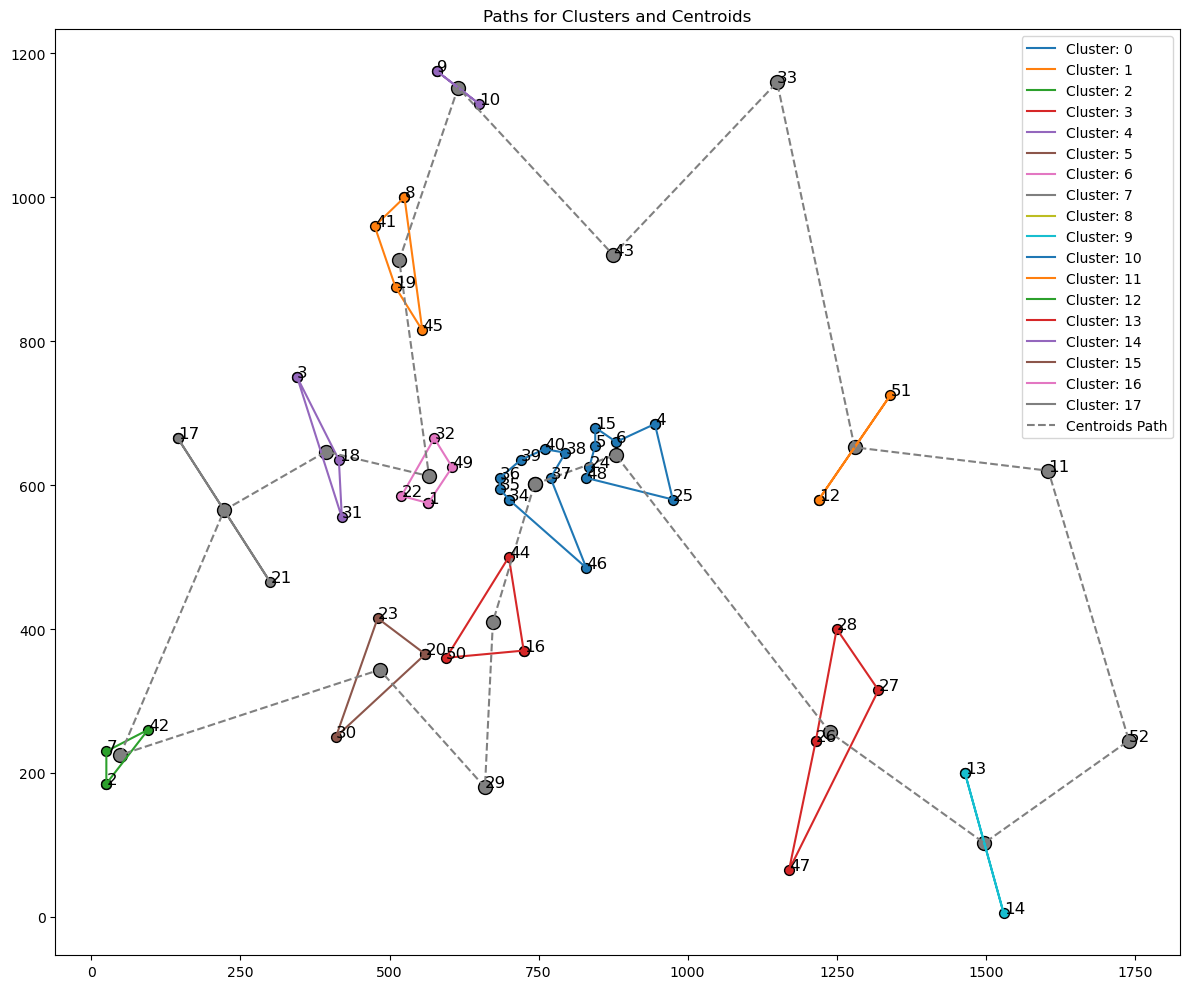

K: 18
Custo: 8073.606411631


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



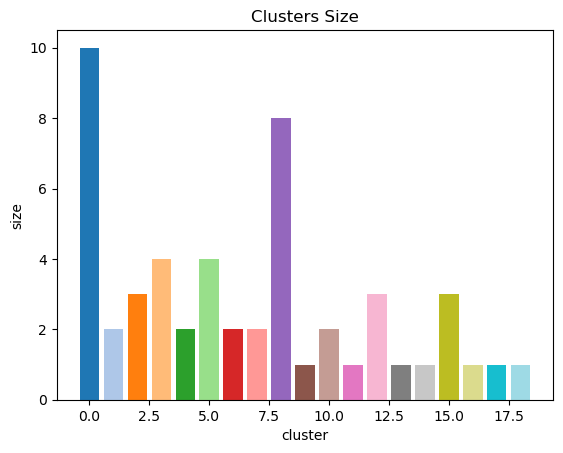

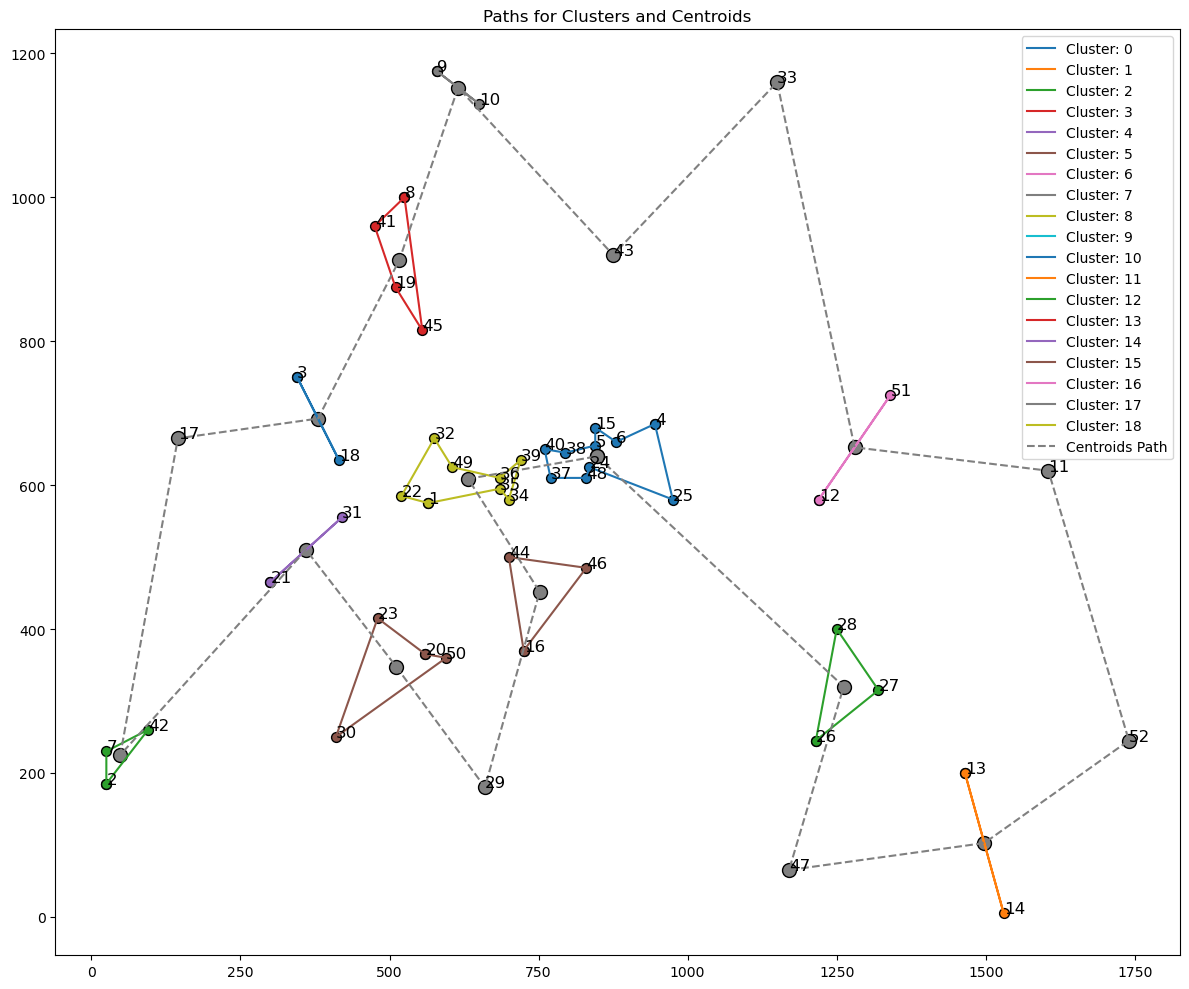

K: 19
Custo: 8488.059949768545


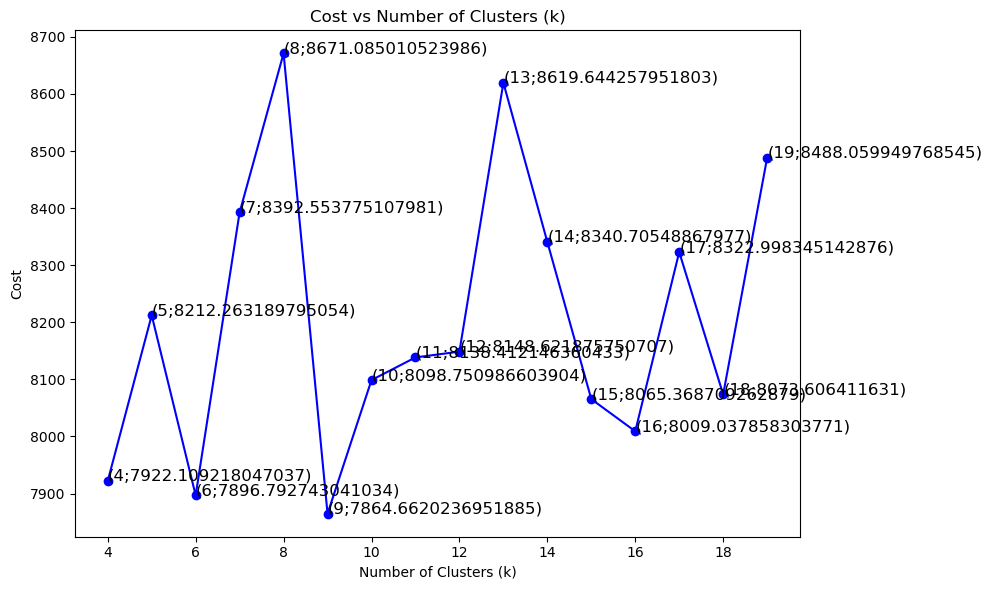

[(4, 7922.109218047037), (5, 8212.263189795054), (6, 7896.792743041034), (7, 8392.553775107981), (8, 8671.085010523986), (9, 7864.6620236951885), (10, 8098.750986603904), (11, 8138.412146360433), (12, 8148.621875750707), (13, 8619.644257951803), (14, 8340.70548867977), (15, 8065.368709262879), (16, 8009.037858303771), (17, 8322.998345142876), (18, 8073.606411631), (19, 8488.059949768545)]


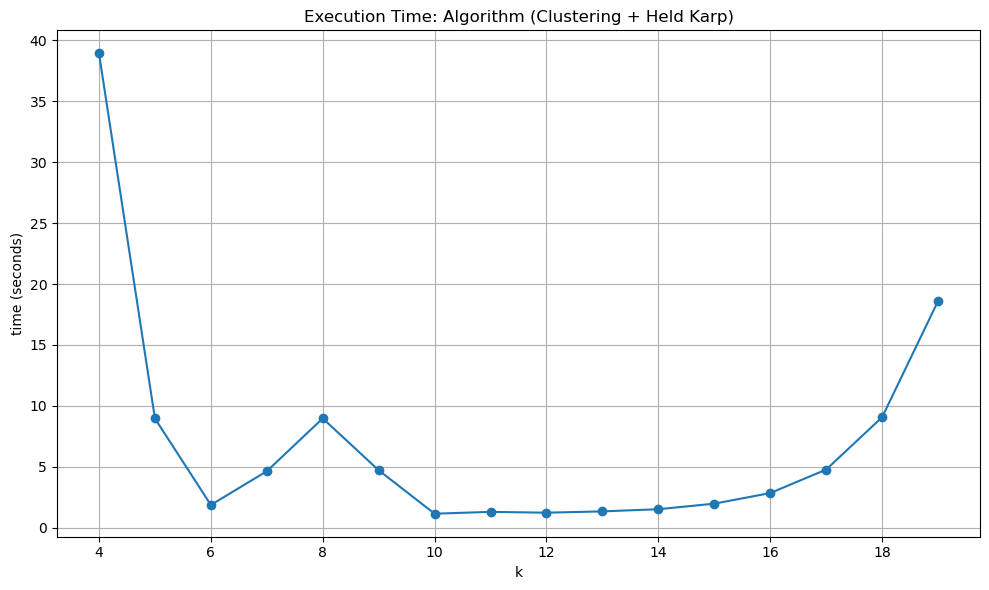

In [24]:
filepath = 'tsplib/berlin52.tsp'
instance = Instance(filepath)

plot_nodes(instance.nodes)

# # Calcula o comprimento do caminho mínimo e obtém o caminho percorrido
# opt, path = held_karp(instance.nodes, instance.edge_weight_type)

max_nodes = 20
# Number of clusters to create (you may adjust this as needed)
num_clusters = 20

costs = []
execution_times = []
K = []

for k in range(1, num_clusters):
    start_time = time.time()
    try:

        # Extraia apenas as coordenadas (latitude e longitude)
        coordinates = instance.nodes[:, :2]

        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(coordinates)

        # Initialize list to store solutions for each cluster
        paths = []
        opts = []
        clusters_size = []

        for cluster_id in range(k):
            # Get nodes belonging to current cluster
            nodes = instance.nodes[clusters == cluster_id]

            # Check if the number of nodes in the current cluster exceeds max_nodes
            if len(nodes) > max_nodes:
                raise ClusterNodeLimitError(f"K = {k} exceeds {max_nodes} nodes.")

        # Solve each cluster using Held-Karp algorithm
        for cluster_id in range(k):
            # Get nodes belonging to current cluster
            nodes = instance.nodes[clusters == cluster_id]

            # # Check if the number of nodes in the current cluster exceeds max_nodes
            # if len(nodes) > max_nodes:
            #     raise ClusterNodeLimitError(f"Cluster {cluster_id} has {len(nodes)} nodes, which exceeds {max_nodes} nodes.")
            

            # Solve TSP for the current cluster using Held-Karp algorithm
            opt, path = held_karp(nodes, instance.edge_weight_type)
            # print(f"Cluster {cluster_id}: Optimal Length = {opt}, Path = \n{path}")
            paths.append(path)
            opts.append(opt)
            clusters_size.append(len(nodes))

        # ==============================
        plot_bar_chart(list(range(0, len(clusters_size))), clusters_size, "cluster", "size", "Clusters Size")
        # ==============================

        centroids = kmeans.cluster_centers_
        centroid_ids = np.arange(len(centroids)).reshape(-1, 1)
        centroids_with_ids = np.hstack((centroids, centroid_ids))

        opt, path_centroids = held_karp(centroids_with_ids, instance.edge_weight_type)
        # plot_path(path_centroids, opt)
        # plot_geo(path_centroids, "centroids_path.html")
        # print(f"Centroids: Optimal Length = {opt}, Path = \n{path_centroids}")

        plot_path_nodes_and_centroids(paths, path_centroids)

        # Matriz de distâncias completa dos nós
        dist_matrix = np.zeros((len(instance.nodes), len(instance.nodes)))
        for i in range(len(instance.nodes)):
            for j in range(len(instance.nodes)):
                dist_matrix[i, j] = distance(instance.nodes[i], instance.nodes[j], instance.edge_weight_type)

        # Reorganize e otimize os caminhos de acordo com a ordem dos centróides
        join = []

        for idx in path_centroids[:, 2]:
            intra_path = paths[int(idx) - 1]
            min_cost = float('inf')  # Inicializa 'min_cost' com um valor infinito
            min_path = []  # Inicializa 'min_path'
            tam = len(join)
            
            if tam > 0:
                for i in range(tam + 1):  # +1 para considerar inserção no final
                    circulars = circular_permutations(intra_path)
                    # print(f"circulars: {circulars}")
                    for circular in circulars:
                        # print(f"      circular: {circular}")
                        copy = join[:i] + circular + join[i:]
                        cost = calculate_total_distance(copy, dist_matrix)
                        if cost < min_cost:
                            min_cost = cost
                            min_path = copy

                # print(f"Melhor permutação: {min_path}")
                join = min_path  # Atualiza 'join' com o caminho de menor custo
            else:
                join.extend(intra_path)
            
            # join = opt2(join, dist_matrix)

            # plot_path(join, calculate_total_distance(join, dist_matrix))

        # Otimizar o caminho final
        join = opt2(join, dist_matrix)
        # plot_path(join, calculate_total_distance(join, dist_matrix))
        
        print(f"K: {k}")
        #plot_path_and_tour(join, instance.tour, dist_matrix)
        path_cost = calculate_total_distance(join, dist_matrix)
        print(f'Custo: {path_cost}')
        costs.append((k, path_cost))
        end_time = time.time()
        execution_times.append(end_time-start_time)
        K.append(k)
    except ClusterNodeLimitError as e:
        print(f"Skipping cluster with {e}")
        continue

plot_costs(costs)
print(costs)

# Plotar a duração do tempo de execução
plot_execution_time(K, execution_times, "k", "time (seconds)", "Execution Time: Algorithm (Clustering + Held Karp)")

# Heurística Simples (Nearest Neighbor + 2-Opt)

In [25]:
import numpy as np

def nearest_neighbor(matrix):
    num_cities = len(matrix)
    visited = [False] * num_cities
    path = []
    
    # Começar do primeiro nó
    current = 0
    path.append(current)
    visited[current] = True
    
    # Enquanto houver cidades não visitadas
    while len(path) < num_cities:
        nearest_city = None
        nearest_city_distance = np.inf
        
        # Encontrar a cidade mais próxima
        for i in range(num_cities):
            if not visited[i] and matrix[current][i] < nearest_city_distance:
                nearest_city = i
                nearest_city_distance = matrix[current][i]
        
        # Ir para a cidade mais próxima
        current = nearest_city
        path.append(current)
        visited[current] = True
    
    # Voltar para a primeira cidade para completar o ciclo
    path.append(path[0])
    
    return path

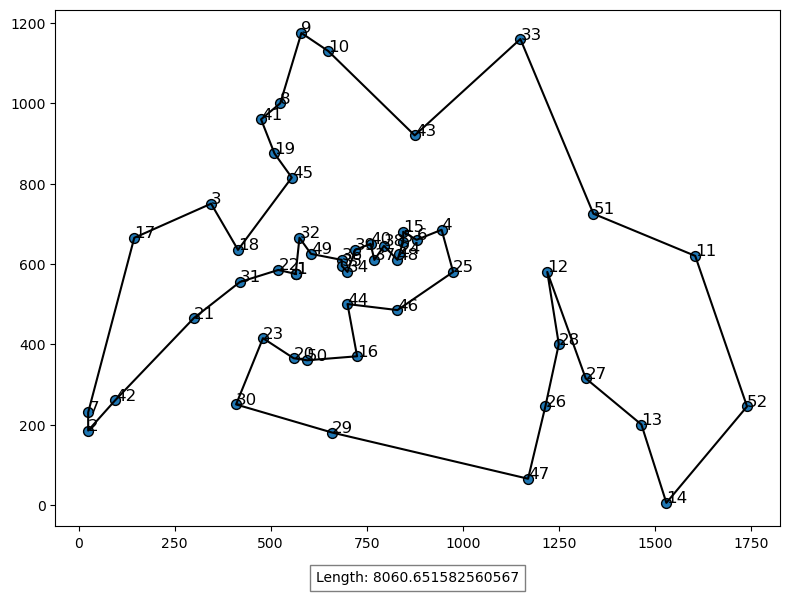

In [26]:
filepath = 'tsplib/berlin52.tsp'
instance = Instance(filepath)

# Matriz de distâncias completa dos nós
dist_matrix = np.zeros((len(instance.nodes), len(instance.nodes)))
for i in range(len(instance.nodes)):
    for j in range(len(instance.nodes)):
        dist_matrix[i, j] = distance(instance.nodes[i], instance.nodes[j], instance.edge_weight_type)

path = nearest_neighbor(dist_matrix)
path = [np.array(node) for node in instance.nodes[path]]
path = opt2(path, dist_matrix)
plot_path(path, calculate_total_distance(path, dist_matrix))

# Analysis

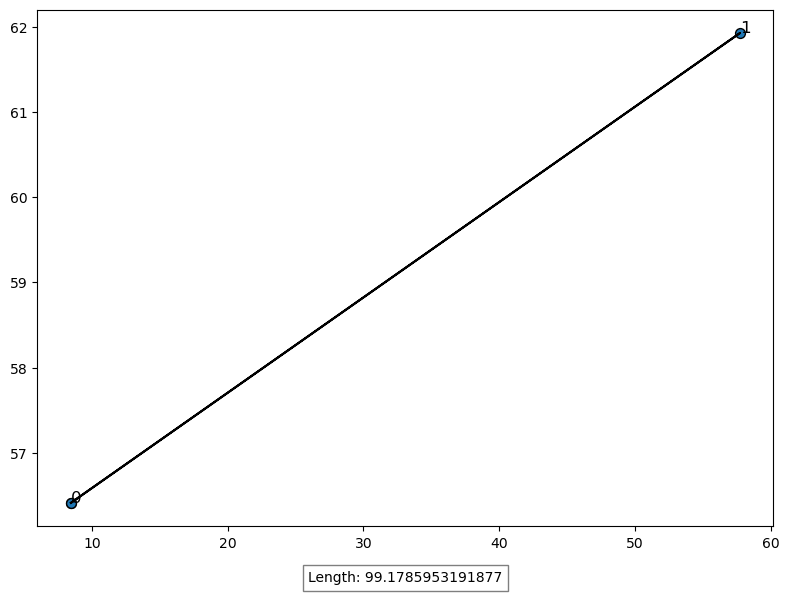

Number of nodes: 2, Execution time: 0.1043 seconds


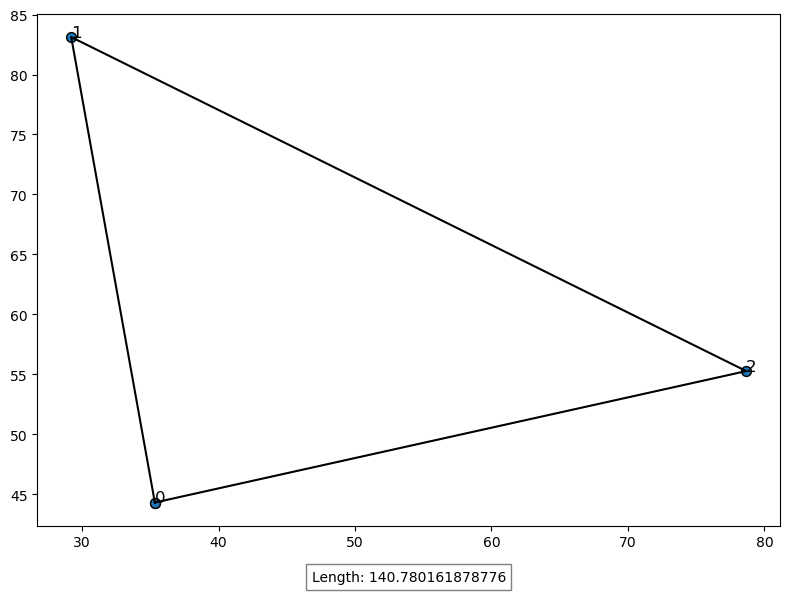

Number of nodes: 3, Execution time: 0.1116 seconds


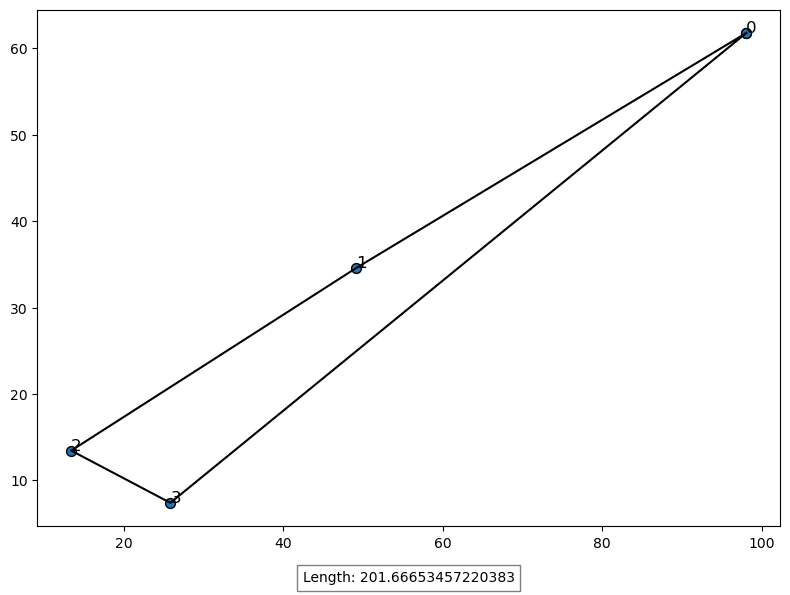

Number of nodes: 4, Execution time: 0.1059 seconds


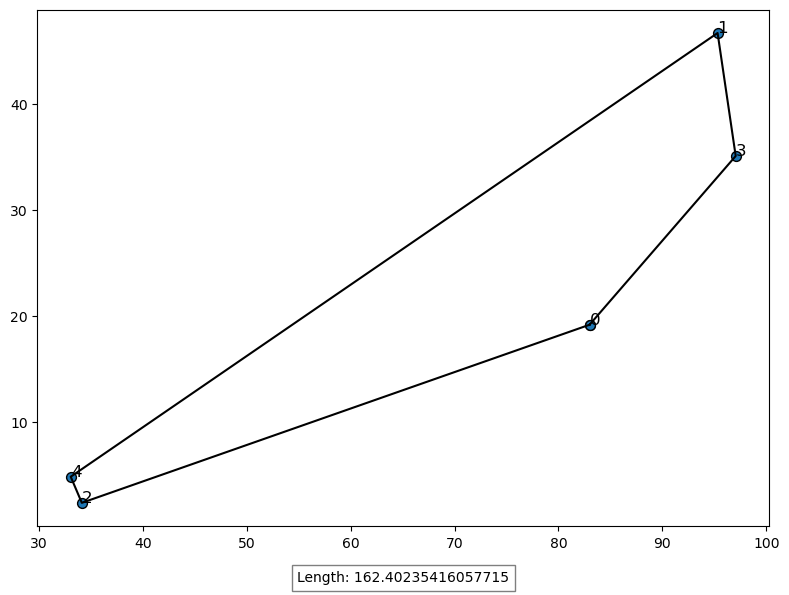

Number of nodes: 5, Execution time: 0.1090 seconds


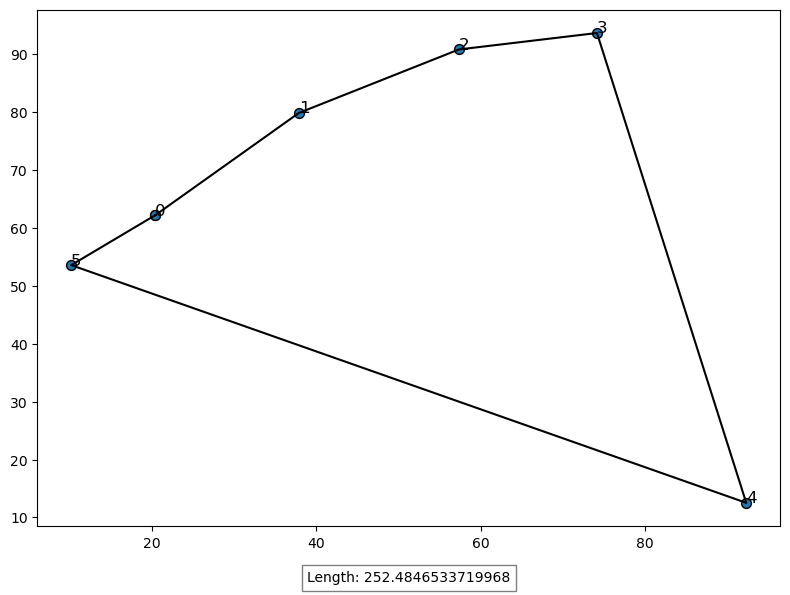

Number of nodes: 6, Execution time: 0.1101 seconds


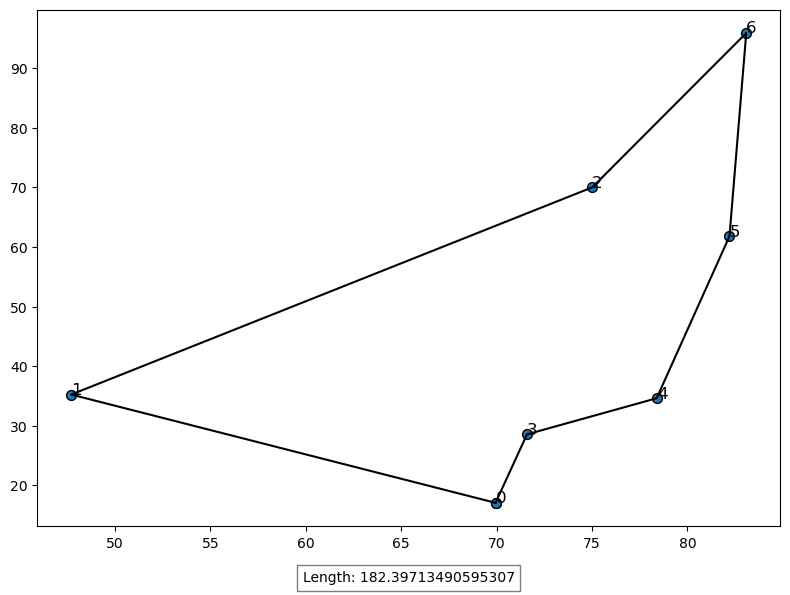

Number of nodes: 7, Execution time: 0.1197 seconds


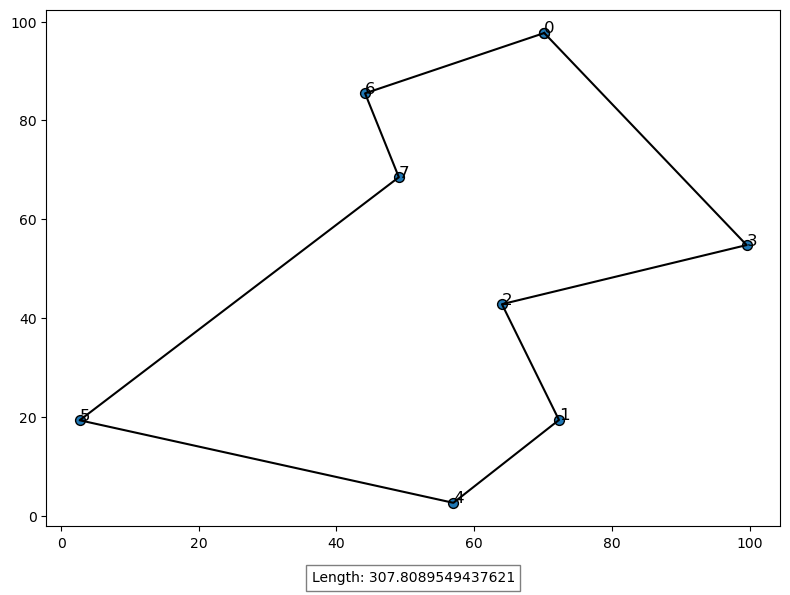

Number of nodes: 8, Execution time: 0.1101 seconds


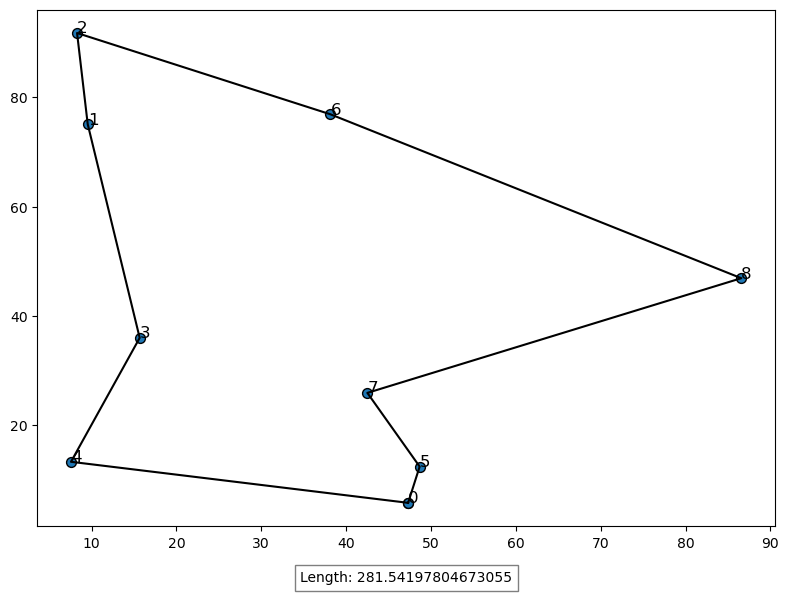

Number of nodes: 9, Execution time: 0.1179 seconds


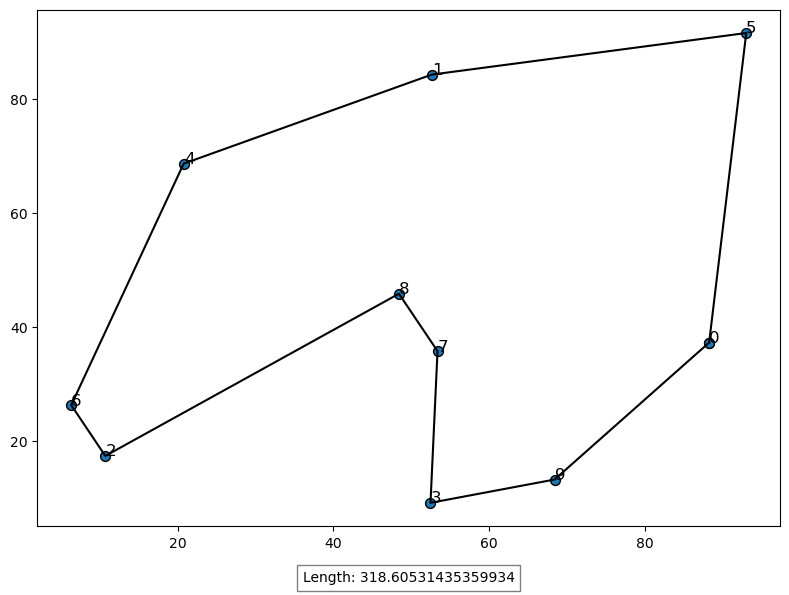

Number of nodes: 10, Execution time: 0.1114 seconds


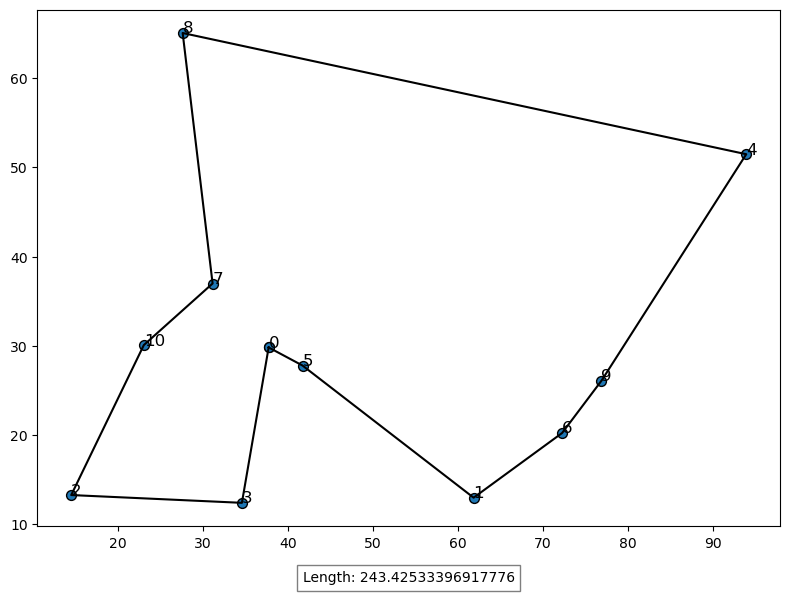

Number of nodes: 11, Execution time: 0.1431 seconds


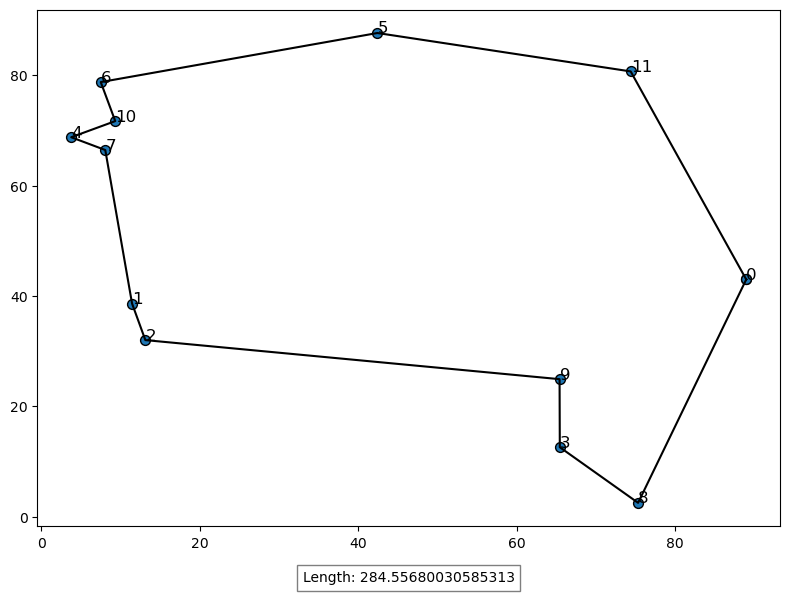

Number of nodes: 12, Execution time: 0.1896 seconds


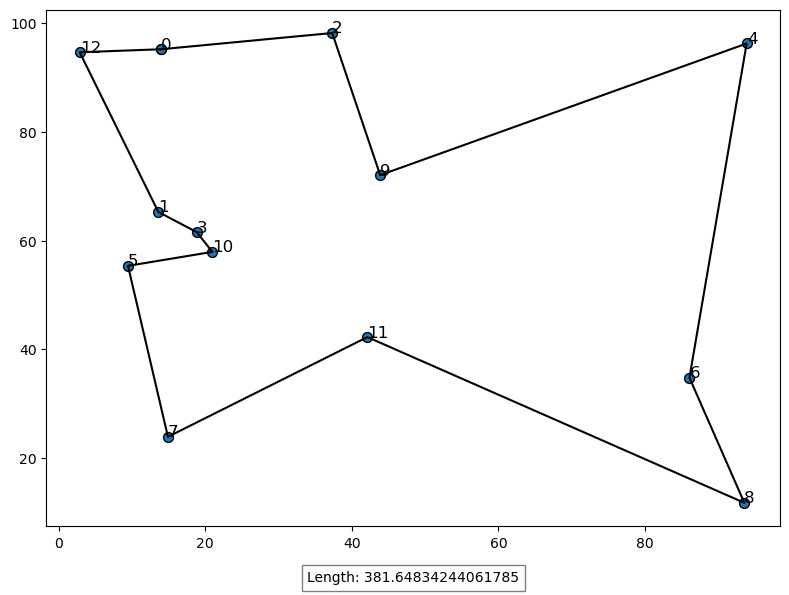

Number of nodes: 13, Execution time: 0.2400 seconds


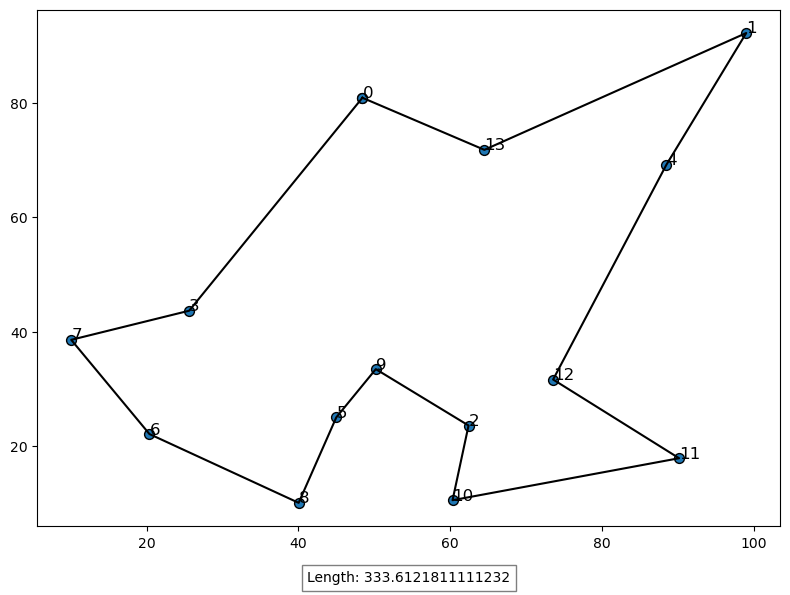

Number of nodes: 14, Execution time: 0.4017 seconds


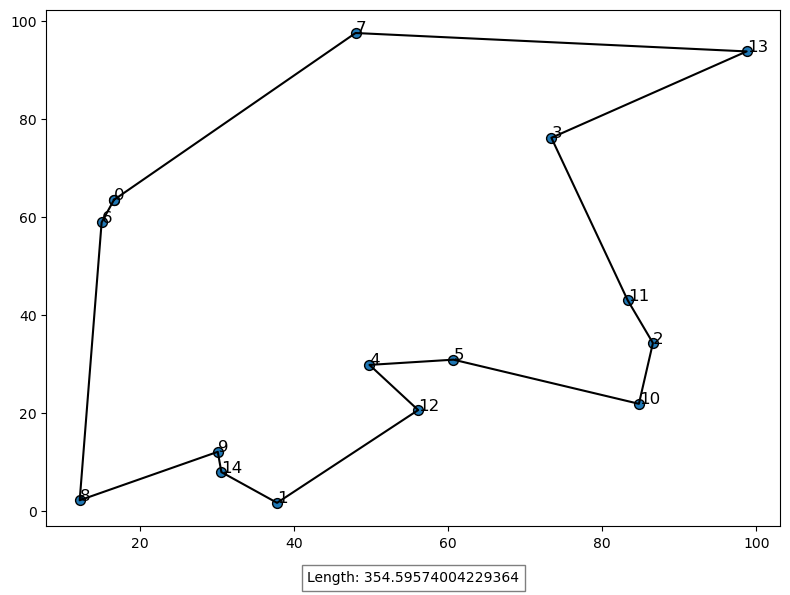

Number of nodes: 15, Execution time: 0.7624 seconds


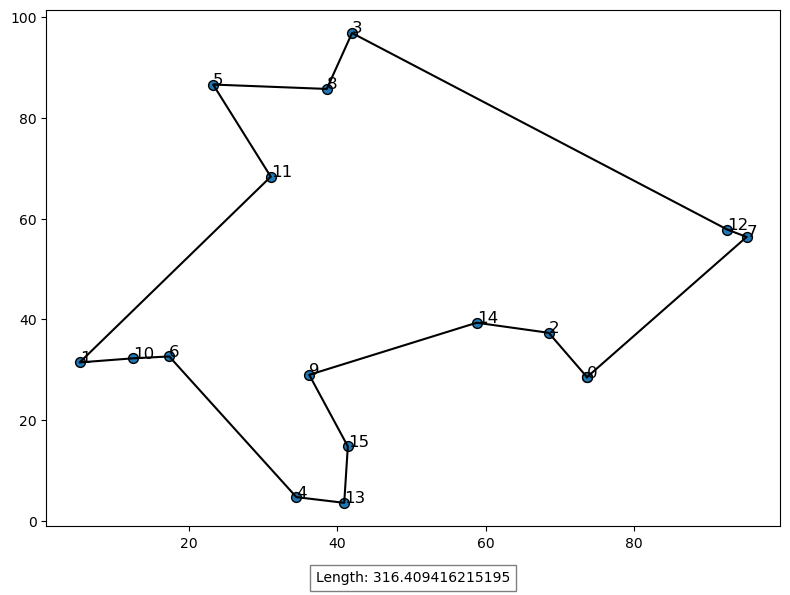

Number of nodes: 16, Execution time: 1.5954 seconds


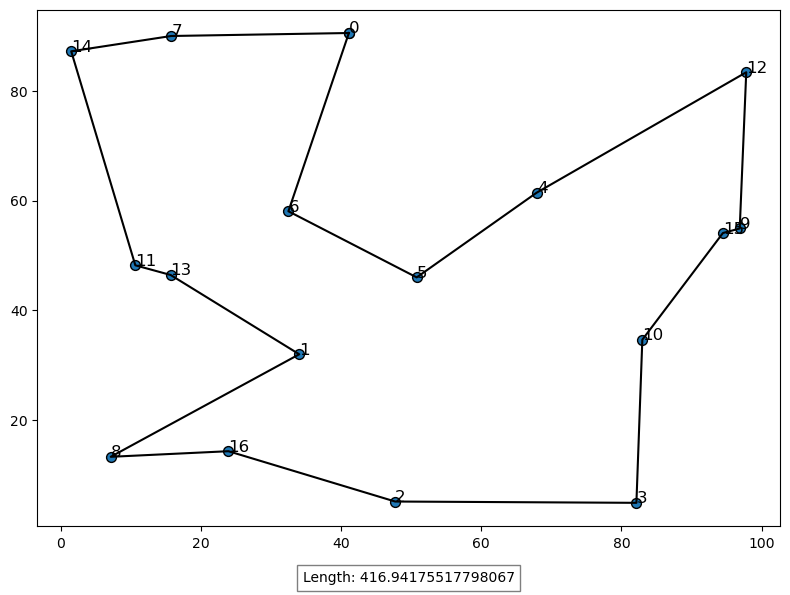

Number of nodes: 17, Execution time: 3.7576 seconds


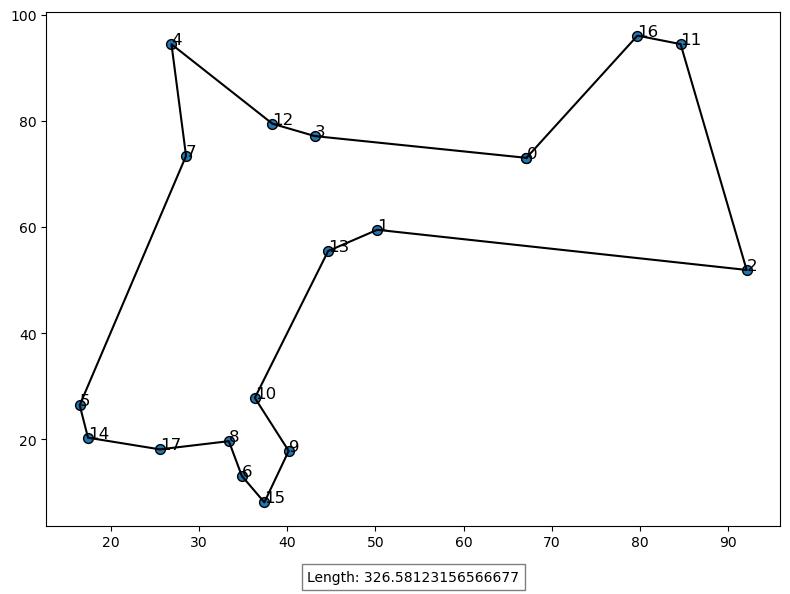

Number of nodes: 18, Execution time: 7.9189 seconds


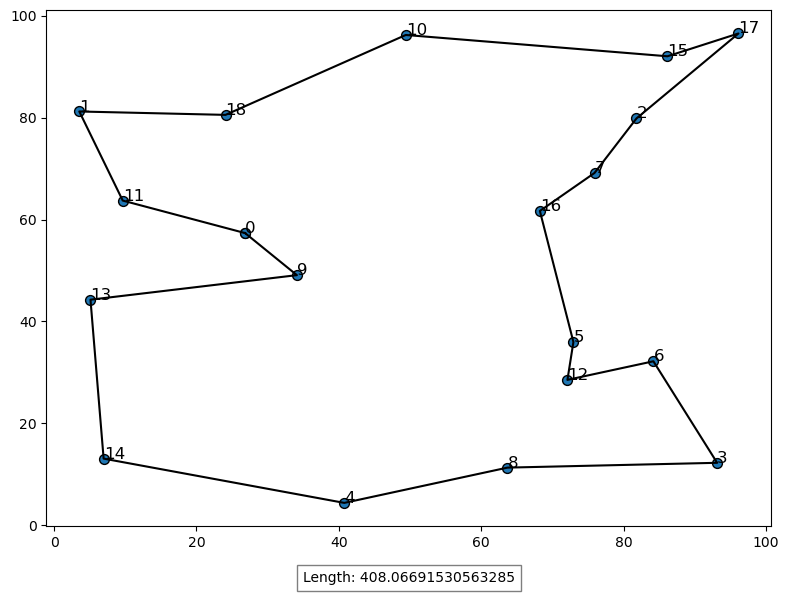

Number of nodes: 19, Execution time: 17.2401 seconds


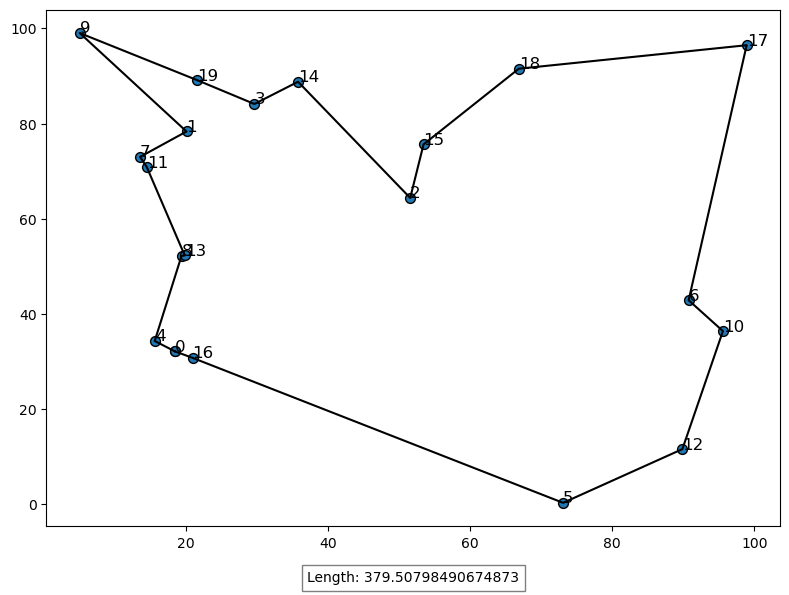

Number of nodes: 20, Execution time: 37.6650 seconds


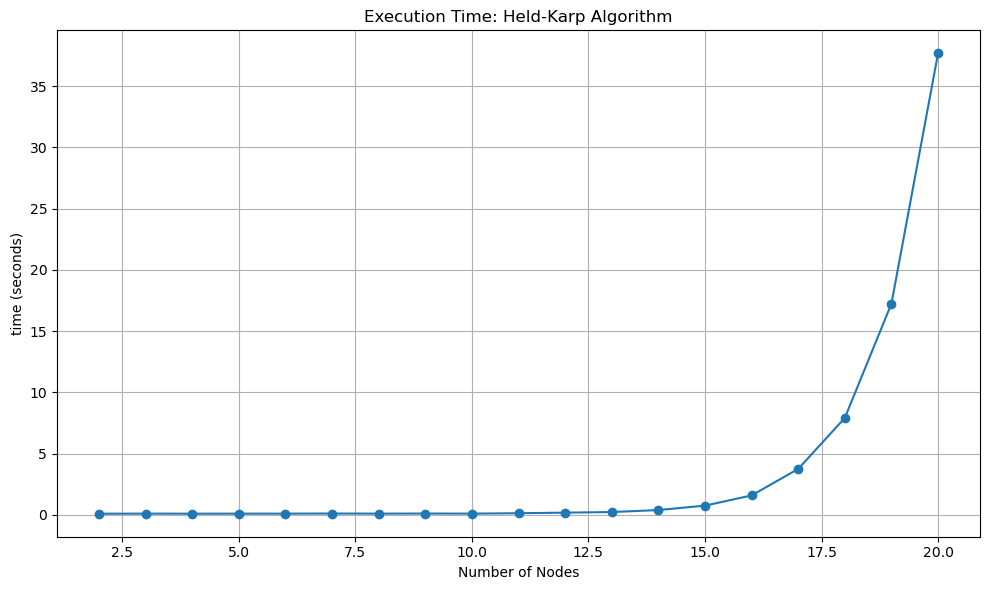

In [27]:
# Função para gerar instâncias aleatórias de nós com ID
def generate_random_nodes(num_nodes):
    lat = np.random.rand(num_nodes) * 100  # Gera coordenadas aleatórias entre 0 e 100
    lon = np.random.rand(num_nodes) * 100  # Gera coordenadas aleatórias entre 0 e 100
    ids = np.arange(num_nodes)  # Cria IDs únicos para cada nó
    nodes = np.column_stack((lat, lon, ids))  # Cria uma matriz com lat, lon e id
    return nodes

# Função para medir o tempo de execução do Held-Karp
def measure_held_karp_time(nodes):
    start_time = time.time()
    opt, path = held_karp(nodes, 'EUC_2D')
    plot_path(path, opt)
    end_time = time.time()
    return end_time - start_time


num_nodes_list = list(range(2, 21))  # Lista de números de nós para testar
execution_times = []

for num_nodes in num_nodes_list:
    nodes = generate_random_nodes(num_nodes)
    execution_time = measure_held_karp_time(nodes)
    execution_times.append(execution_time)
    print(f"Number of nodes: {num_nodes}, Execution time: {execution_time:.4f} seconds")

# Plotar a duração do tempo de execução
plot_execution_time(num_nodes_list, execution_times, "Number of Nodes", "time (seconds)", "Execution Time: Held-Karp Algorithm")